# Trajectory Visualization

Visualization of Gene Score, Expression and ChromVAR along trajectories.

Inputs:
1. ATAC metadata
2. ATAC pseudotime
3. ATAC ChromVAR
4. ArchR Gene Score
5. RNA Seurat object
6. RNA clusters (transfered from ATAC)
7. CCA or similar coembedding coordinates for ATAC+RNA
8. Cluster and Day configs
9. Motif group metadata (e.g. Vierstra motif clusters)

In [1]:
library(Seurat)
library(ArchR)
library(RANN)
library(patchwork)
library(mgcv) # for smoothing

Loading required package: ggplot2

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    unio

In [2]:
DAYS = c("D0", "D2", "D4", "D6", "D8", "D10", "D12", "D14")

In [3]:
addArchRThreads(threads = 32) 

Setting default number of Parallel threads to 32.



In [4]:
addArchRGenome("hg38")

Setting default genome to Hg38.



## Load Inputs

### ATAC MetaData

In [5]:
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../20200206_pmat_snapATAC/sessions/20201022_n53906/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$cells = rownames(metaData) # for cicero
metaData$sample = factor(metaData$sample, levels=DAYS)
dim(metaData)
head(metaData, 5)

[1] 53906     6

barcode          sample umap1    umap2     cluster
D0_AACGCGAGAAGGACCA AACGCGAGAAGGACCA D0     8.373301 -4.292619 5      
D0_AACGCGCTGTCTGTGA AACGCGCTGTCTGTGA D0     2.033609 -7.860645 5      
D0_ACCTATGGACTCGATA ACCTATGGACTCGATA D0     3.093788 -7.469210 5      
D0_ACGCAGAGATAACCCA ACGCAGAGATAACCCA D0     6.001364 -7.523576 5      
D0_ACTCGCTACTTGTGAC ACTCGCTACTTGTGAC D0     3.343237 -8.114589 5      
                    cells              
D0_AACGCGAGAAGGACCA D0_AACGCGAGAAGGACCA
D0_AACGCGCTGTCTGTGA D0_AACGCGCTGTCTGTGA
D0_ACCTATGGACTCGATA D0_ACCTATGGACTCGATA
D0_ACGCAGAGATAACCCA D0_ACGCAGAGATAACCCA
D0_ACTCGCTACTTGTGAC D0_ACTCGCTACTTGTGAC

### Cluster Config

In [6]:
cluster_config = read.table("../../figures_factory/configs/cluster.tsv", comment.char = '', sep='\t', header=T)
cluster_config

cluster colour  description            new_cluster
1   1      #A6D854 Pre-iPSC               14         
2   2      #F0A118 Intermediate           12         
3   3      #E85F6D Fibroblast-like         3         
4   4      #006658 Neural-like             8         
5   5      #B03743 Fibroblast              1         
6   6      #CF175A Fibroblast-like         4         
7   7      #78A824 Pre-iPSC               13         
8   8      #F4D5CD Intermediate           11         
9   9      #D4B81C Intermediate            9         
10 10      #F01D35 Fibroblast-like         5         
11 11      #7C2730 Fibroblast-like         2         
12 12      #F7A6C2 Keratinocyte-like       6         
13 13      #406614 Partially-reprogrammed 10         
14 14      #F0520A Early intermediate      7

In [7]:
metaData$cluster_new_id = cluster_config[metaData$cluster, "new_cluster"]

### Day Config

In [8]:
day_config = read.table("../../figures_factory/configs/day.tsv", 
                        comment.char = '', 
                        sep='\t', 
                        header=T,
                       stringsAsFactor=F)
rownames(day_config) = day_config$day
day_config

day colour 
D0  D0  #A61C24
D2  D2  #FF70A6
D4  D4  #D6E82F
D6  D6  #B14AED
D8  D8  #2D3142
D10 D10 #FC7753
D12 D12 #0AABB7
D14 D14 #336699

### ArchR Gene Score

In [9]:
ArrowFiles = c('D0.arrow',
               'D2.arrow',
               'D4.arrow',
               'D6.arrow',
               'D8.arrow',
               'D10.arrow',
               'D12.arrow',
               'D14.arrow')
#              'H1.arrow')

In [10]:
archr_proj <- ArchRProject(
  ArrowFiles = paste("/srv/scratch/surag/scATAC-reprog/arrow/", ArrowFiles, sep=''), 
  outputDirectory = "./tmp/",
  copyArrows = FALSE #This is recommened so that you maintain an unaltered copy for later usage.
)

Using GeneAnnotation set by addArchRGenome(Hg38)!

Using GeneAnnotation set by addArchRGenome(Hg38)!

Validating Arrows...

Getting SampleNames...



Getting Cell Metadata...



Merging Cell Metadata...

Initializing ArchRProject...


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,-

In [11]:
all(paste(metaData$sample, metaData$barcode, sep='#') %in% archr_proj$cellNames)

[1] TRUE

In [12]:
# subset to cells
archr_proj = archr_proj[paste(metaData$sample, metaData$barcode, sep='#'), ]

In [13]:
getAvailableMatrices(archr_proj)

[1] "GeneIntegrationMatrix" "GeneScoreMatrix"       "PeakMatrix"           
[4] "TileMatrix"

In [14]:
archr_gene_score = getMatrixFromProject(archr_proj, "GeneScoreMatrix")
dim(archr_gene_score)

ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-1933f2f4fa3-Date-2020-11-25_Time-04-34-09.log
If there is an issue, please report to github with logFile!

2020-11-25 04:35:28 : Organizing colData, 1.313 mins elapsed.

2020-11-25 04:35:28 : Organizing rowData, 1.315 mins elapsed.

2020-11-25 04:35:28 : Organizing Assays (1 of 1), 1.315 mins elapsed.

2020-11-25 04:36:10 : Constructing SummarizedExperiment, 2.01 mins elapsed.

2020-11-25 04:36:11 : Finished Matrix Creation, 2.028 mins elapsed.



[1] 24919 53906

In [15]:
archr_gene_score_mat = archr_gene_score@assays@data$GeneScoreMatrix
rownames(archr_gene_score_mat) = rowData(archr_gene_score)$name
colnames(archr_gene_score_mat) = sub("#", "_", rownames(colData(archr_gene_score)))
# reorder
archr_gene_score_mat = archr_gene_score_mat[, rownames(metaData)]

In [16]:
sum(is.na(archr_gene_score_mat))

[1] 0

In [17]:
# reclaim some memory
rm(archr_gene_score)
gc()

used      (Mb)   gc trigger (Mb)    max used   (Mb)   
Ncells   7895106  421.7   11519051   615.2   10218573   545.8
Vcells 649477263 4955.2 2130974997 16258.1 2201659243 16797.4

### Seurat Object

In [18]:
rna = readRDS("../20200828_RNA_Seurat/sessions/20200913_n59369/seurat.rds")
rna$tech = "rna"

### ATAC-RNA Label Transfer

In [19]:
atac.rna.label = read.table("../../analysis/20200828_RNA_Seurat/sessions/20200913_n59369/atac.20201022_n53906.cluster.transfer.tsv",
                           header=T)
rownames(atac.rna.label) = atac.rna.label$barcode
atac.rna.label$barcode = NULL

all(rownames(atac.rna.label)==colnames(rna))

# transfer to new cluster
atac.rna.label$atac_new_cluster = cluster_config[atac.rna.label$atac_cluster, "new_cluster"]

head(atac.rna.label)

[1] TRUE

sample atac_cluster atac_new_cluster
AAACCCAAGAGTGACC-1 D0     5            1               
AAACCCAAGTGCCAGA-1 D0     5            1               
AAACCCACACCATTCC-1 D0     5            1               
AAACCCACACGCGTCA-1 D0     5            1               
AAACCCAGTCCATAGT-1 D0     5            1               
AAACCCAGTTATTCTC-1 D0     5            1

### ATAC Pseudotime

In [20]:
pseudotime = read.table("../20200217_trajectory/sessions/20201022_n53906/pseudotime.tsv")
rownames(pseudotime) = pseudotime$sample_barcode
pseudotime$sample_barcode = NULL
all(rownames(pseudotime) == rownames(metaData))
head(pseudotime)

[1] TRUE

dpt_pseudotime
D0_AACGCGAGAAGGACCA 0.00000000    
D0_AACGCGCTGTCTGTGA 0.20646924    
D0_ACCTATGGACTCGATA 0.17054172    
D0_ACGCAGAGATAACCCA 0.09116346    
D0_ACTCGCTACTTGTGAC 0.16613631    
D0_AGACTACTGGCAGTTT 0.05593833

### ChromVAR Scores

In [21]:
# Load ChromVAR (needs to be updated)
chromvar = read.table(gzfile("../20200607_ChromVAR/out/20201020_n62402/20201119_bpnet.no_iPSC.FDR_0.1_hits.tsv"),
                            check.names=FALSE, # keeps + in FOS+JUN instead of converting to FOS.JUN
                      sep='\t')
all(rownames(metaData) %in% rownames(chromvar))
chromvar = chromvar[rownames(metaData),] 
head(chromvar)

[1] TRUE

AP2A_HUMAN.H11MO.0.A AP2A_MOUSE.H11MO.0.A
D0_AACGCGAGAAGGACCA -0.12294065          -0.09352625         
D0_AACGCGCTGTCTGTGA -0.12821733          -0.09127279         
D0_ACCTATGGACTCGATA -0.09000103          -0.07525123         
D0_ACGCAGAGATAACCCA -0.13996900          -0.11293790         
D0_ACTCGCTACTTGTGAC -0.29016466          -0.26960139         
D0_AGACTACTGGCAGTTT -0.05789882          -0.03753335         
                    AP2C_HUMAN.H11MO.0.A Ascl2.mouse_bHLH_1
D0_AACGCGAGAAGGACCA -0.10794921           0.08798450       
D0_AACGCGCTGTCTGTGA -0.11971037          -0.05039826       
D0_ACCTATGGACTCGATA -0.05044384           0.02199156       
D0_ACGCAGAGATAACCCA -0.12036074           0.03213452       
D0_ACTCGCTACTTGTGAC -0.26274589          -0.08115598       
D0_AGACTACTGGCAGTTT -0.03960972           0.07398756       
                    ATF1_MOUSE.H11MO.0.B BATF+JUN_MA0462.1 CEBPA_MA0102.3
D0_AACGCGAGAAGGACCA  0.018353336         0.03361392         0.34264057   
D0_AACGCGCTGTCTGTGA -0.165470322         0.17952061        -0.06281021   
D0_ACCTATGGACTCGATA  0.064826831         0.16002619         0.17504433   
D0_ACGCAGAGATAACCCA  0.007410609         0.10376001         0.06106466   
D0_ACTCGCTACTTGTGAC  0.169576565         0.17302266         0.05314971   
D0_AGACTACTGGCAGTTT  0.126405154         0.12559693         0.39322449   
                    CEBPB_MOUSE.H11MO.0.A CREB1_MA0018.3 CREB3_bZIP_1 ⋯
D0_AACGCGAGAAGGACCA  0.22410861            0.12877157     0.10686871  ⋯
D0_AACGCGCTGTCTGTGA -0.08282114            0.12301088     0.12257224  ⋯
D0_ACCTATGGACTCGATA  0.16178425           -0.01575793    -0.04535254  ⋯
D0_ACGCAGAGATAACCCA  0.04992117            0.10107298     0.08227665  ⋯
D0_ACTCGCTACTTGTGAC  0.21316328            0.08961263     0.11566191  ⋯
D0_AGACTACTGGCAGTTT  0.30191576            0.07435968     0.10389412  ⋯
                    VEZF1_HUMAN.H11MO.0.C YY1_MA0095.2 ZBTB18_MA0698.1
D0_AACGCGAGAAGGACCA -0.05705881           -0.035062317  0.0654240384  
D0_AACGCGCTGTCTGTGA -0.05607968           -0.068237933 -0.0634596941  
D0_ACCTATGGACTCGATA -0.04363534           -0.032693962  0.0083265061  
D0_ACGCAGAGATAACCCA -0.06270160           -0.157120673  0.0279788745  
D0_ACTCGCTACTTGTGAC -0.11856937            0.002780547 -0.2417367283  
D0_AGACTACTGGCAGTTT -0.02603083           -0.093000115  0.0005260283  
                    ZBTB33_MA0527.1 ZFX_MOUSE.H11MO.0.B ZN143_HUMAN.H11MO.0.A
D0_AACGCGAGAAGGACCA -0.003564588    -0.03832660         -0.03587245          
D0_AACGCGCTGTCTGTGA  0.032931037    -0.04811726         -0.02580824          
D0_ACCTATGGACTCGATA -0.079405863    -0.01814928         -0.03548759          
D0_ACGCAGAGATAACCCA -0.047696751    -0.04599367         -0.09518446          
D0_ACTCGCTACTTGTGAC  0.138115475    -0.13441524         -0.10250958          
D0_AGACTACTGGCAGTTT -0.059059651    -0.01943282         -0.04448186          
                    ZN143_MOUSE.H11MO.0.A ZNF238_C2H2_1 ZNF238_C2H2_2
D0_AACGCGAGAAGGACCA -0.03941892            0.04882215    0.0654240384
D0_AACGCGCTGTCTGTGA -0.02821128           -0.04213231   -0.0634596941
D0_ACCTATGGACTCGATA -0.01061891            0.03299011    0.0083265061
D0_ACGCAGAGATAACCCA -0.09121124            0.05588418    0.0279788745
D0_ACTCGCTACTTGTGAC -0.17400573           -0.25518424   -0.2417367283
D0_AGACTACTGGCAGTTT -0.02886792            0.02527477    0.0005260283
                    ZNF76_HUMAN.H11MO.0.C
D0_AACGCGAGAAGGACCA -0.06306453          
D0_AACGCGCTGTCTGTGA -0.06673984          
D0_ACCTATGGACTCGATA -0.03533180          
D0_ACGCAGAGATAACCCA -0.05976590          
D0_ACTCGCTACTTGTGAC -0.14147841          
D0_AGACTACTGGCAGTTT -0.04497569

### Motif Group Metadata

In [22]:
motifs = read.table("/srv/www/kundaje/surag/resources/motif_archetypes/motifs.tsv", 
                    header=T,
                   stringsAsFactors=F)
rownames(motifs) = motifs$Motif
motifs$Motif = NULL
dim(motifs)
head(motifs)

[1] 2174    8

Cluster_ID Database          Consensus   
LHX6_homeodomain_3       1          Taipale_Cell_2013 TGATTGCAATCA
Lhx8.mouse_homeodomain_3 1          Taipale_Cell_2013 TGATTGCAATTA
LHX2_MOUSE.H11MO.0.A     2          HOCOMOCO_v11      ACTAATTAAC  
LHX2_HUMAN.H11MO.0.A     2          HOCOMOCO_v11      AACTAATTAAAA
LHX3_MOUSE.H11MO.0.C     2          HOCOMOCO_v11      TTAATTAGC   
NOBOX_HUMAN.H11MO.0.C    2          HOCOMOCO_v11      ACCAATTAG   
                         Relative_orientation Width Left_offset Right_offset
LHX6_homeodomain_3       +                    12    0            0          
Lhx8.mouse_homeodomain_3 -                    12    0            0          
LHX2_MOUSE.H11MO.0.A     -                    10    7            9          
LHX2_HUMAN.H11MO.0.A     -                    12    6            8          
LHX3_MOUSE.H11MO.0.C     -                     9    8            9          
NOBOX_HUMAN.H11MO.0.C    -                     9    7           10          
                         Gene 
LHX6_homeodomain_3       LHX6 
Lhx8.mouse_homeodomain_3 Lhx8 
LHX2_MOUSE.H11MO.0.A     LHX2 
LHX2_HUMAN.H11MO.0.A     LHX2 
LHX3_MOUSE.H11MO.0.C     LHX3 
NOBOX_HUMAN.H11MO.0.C    NOBOX

In [23]:
motif_archetypes = read.table("/srv/www/kundaje/surag/resources/motif_archetypes/archetypes.tsv", 
                              header=T,
                             stringsAsFactors=F)
motif_archetypes = motif_archetypes[order(motif_archetypes$Cluster_ID), ]
rownames(motif_archetypes) = motif_archetypes$Cluster_ID
dim(motif_archetypes)
head(motif_archetypes)

[1] 286   8

Cluster_ID Name DBD         Seed_motif            Total_width Consensus_left
1 1          HD/1 homeodomain LHX6_homeodomain_3    12          0             
2 2          HD/2 homeodomain ALX3_MA0634.1         26          8             
3 3          HD/3 homeodomain VENTX_homeodomain_2   21          3             
4 4          HD/4 homeodomain BARX1_MOUSE.H11MO.0.C 17          5             
5 5          HD/5 homeodomain BARX1_homeodomain_1   21          2             
6 6          HD/6 homeodomain BARHL2_MA0635.1       18          1             
  Consensus_right Cluster_size
1 12                2         
2 16              186         
3 20                1         
4 13               17         
5 18                6         
6 16               11

### Coembedding 

In [24]:
head(colnames(rna))

[1] "AAACCCAAGAGTGACC-1" "AAACCCAAGTGCCAGA-1" "AAACCCACACCATTCC-1"
[4] "AAACCCACACGCGTCA-1" "AAACCCAGTCCATAGT-1" "AAACCCAGTTATTCTC-1"

In [25]:
coembedding = read.table("../20200828_RNA_Seurat/sessions/20200913_n59369/atac.20201022_n53906.harmony.cca.tsv")

all(rownames(coembedding) == c(colnames(rna), rownames(metaData)))

dim(coembedding)
head(coembedding)

[1] TRUE

[1] 113275     16

tech harmony_1  harmony_2    harmony_3  harmony_4  
AAACCCAAGAGTGACC-1 rna  0.29773394  0.060780809 0.37018690  0.19983989
AAACCCAAGTGCCAGA-1 rna  0.28259904  0.029176483 0.24774358  0.21202861
AAACCCACACCATTCC-1 rna  0.19551768 -0.003477105 0.25965475  0.04794585
AAACCCACACGCGTCA-1 rna  0.09708915  0.025200052 0.19250754  0.15577251
AAACCCAGTCCATAGT-1 rna  0.14888114  0.085361749 0.05839939  0.03823448
AAACCCAGTTATTCTC-1 rna  0.19591517  0.007899533 0.23764734 -0.10709950
                   harmony_5   harmony_6   harmony_7   harmony_8   harmony_9  
AAACCCAAGAGTGACC-1  0.03008437  0.06041451  0.09856335  0.19131867  0.06073175
AAACCCAAGTGCCAGA-1 -0.01328118 -0.04644758  0.08735725  0.09445840  0.07126179
AAACCCACACCATTCC-1  0.00807158 -0.03565429  0.06622923  0.04148270 -0.15486719
AAACCCACACGCGTCA-1  0.02606344  0.07642032 -0.04095093 -0.08716850 -0.18003416
AAACCCAGTCCATAGT-1  0.21796512 -0.02450189 -0.03054403 -0.06001743 -0.03939952
AAACCCAGTTATTCTC-1 -0.16534263 -0.06857853  0.13958501 -0.02611316  0.04922825
                   harmony_10   harmony_11   harmony_12  harmony_13   
AAACCCAAGAGTGACC-1  0.075185428  0.002075287 -0.00138196  0.0696568031
AAACCCAAGTGCCAGA-1 -0.176678789  0.060986344 -0.06466362 -0.1243335302
AAACCCACACCATTCC-1 -0.072531205  0.099665928  0.24693218 -0.0141086953
AAACCCACACGCGTCA-1  0.090375417 -0.080367276  0.15396999  0.0728915400
AAACCCAGTCCATAGT-1 -0.002925019  0.009129636  0.34440203  0.1157595817
AAACCCAGTTATTCTC-1 -0.039199167  0.089413703  0.05449364 -0.0004101254
                   harmony_14  harmony_15 
AAACCCAAGAGTGACC-1  0.01121586  0.04240550
AAACCCAAGTGCCAGA-1 -0.14314382 -0.05377942
AAACCCACACCATTCC-1 -0.04370388 -0.24862321
AAACCCACACGCGTCA-1  0.05312232 -0.08005201
AAACCCAGTCCATAGT-1 -0.01071808 -0.22913379
AAACCCAGTTATTCTC-1 -0.47859847 -0.03039417

## Preprocessing

### Nearest Neighbor ATAC->RNA

In [26]:
# euclidean RNA NN for each ATAC cell
# atac2rna_nn = nn2(coembedding[coembedding$tech=="rna", 2:ncol(coembedding)],
#                     query=coembedding[coembedding$tech=="atac", 2:ncol(coembedding)],
#                     10)

In [27]:
# head(atac2rna_nn$nn.idx)

In [28]:
# or restrict to same cluster
K = 10
atac2rna_same_cluster_nn = matrix(0, nrow(metaData), K)
for (c in sort(unique(metaData$cluster_new_id))) {
    c2c_nn = nn2(coembedding[coembedding$tech=="rna", 2:ncol(coembedding)][atac.rna.label$atac_new_cluster == c, ],
                    query=coembedding[coembedding$tech=="atac", 2:ncol(coembedding)][metaData$cluster_new_id == c,],
                    K)$nn.idx
    
    orig_rna_idx = which(atac.rna.label$atac_new_cluster == c)
    
    # get original idx
    c2c_nn = matrix(orig_rna_idx[c2c_nn], nrow=nrow(c2c_nn))
        
    atac2rna_same_cluster_nn[metaData$cluster_new_id == c, ] = c2c_nn
}

## Plot

In [101]:
plot_dimred <- function(x, y, col, dimred="UMAP", subset=NULL, sz=0.5) {
    plot_df <- data.frame(x=x, y=y,
                 cluster=col)
    plot_df = plot_df[sample(dim(plot_df)[1]), ]
    
    if (!is.null(subset)) {
        plot_df = plot_df[plot_df$cluster==subset, ]
    }
    
    ggplot(plot_df) +
    geom_point(aes(x=x, y=y, color=cluster), stroke=0, size=sz) +
    theme_classic() +
    xlab(sprintf("%s 1", dimred)) + ylab(sprintf("%s 2", dimred)) +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=12),
          axis.line=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks=element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5)) 
}

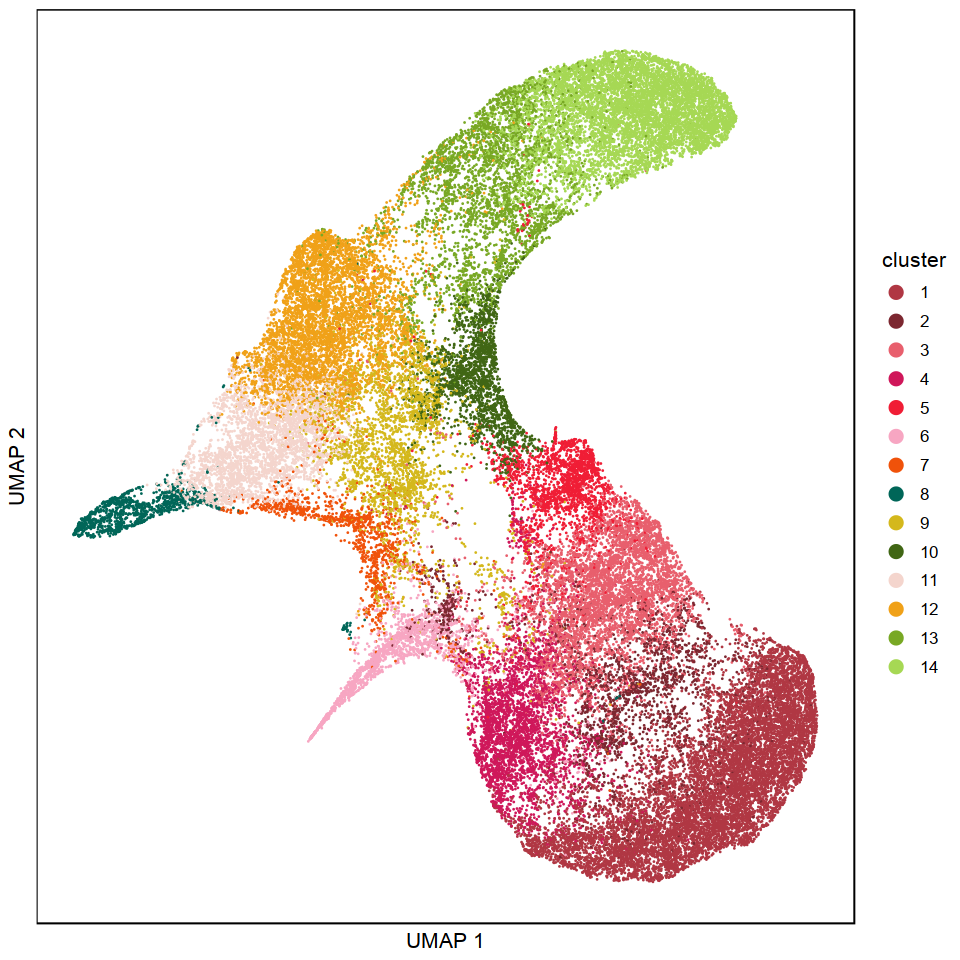

In [27]:
options(repr.plot.width = 8, repr.plot.height = 8)

plot_dimred(metaData$umap1,
           metaData$umap2,
           factor(metaData$cluster_new_id)) + 
scale_color_manual(values=as.character(cluster_config$colour)[order(cluster_config$new_cluster)]) +
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4)))

### Plot All Paths

In [28]:
ALL_PATHS = list(c(1,2,3,4,5), # non reprog
                c(1,6), # ker
                c(1,7,8), # neur
                c(1,7,9,10), # partial
                c(1,7,11,12,13,14)) #reprog


COLS = c("purple", "red", "blue", "tomato", "black")

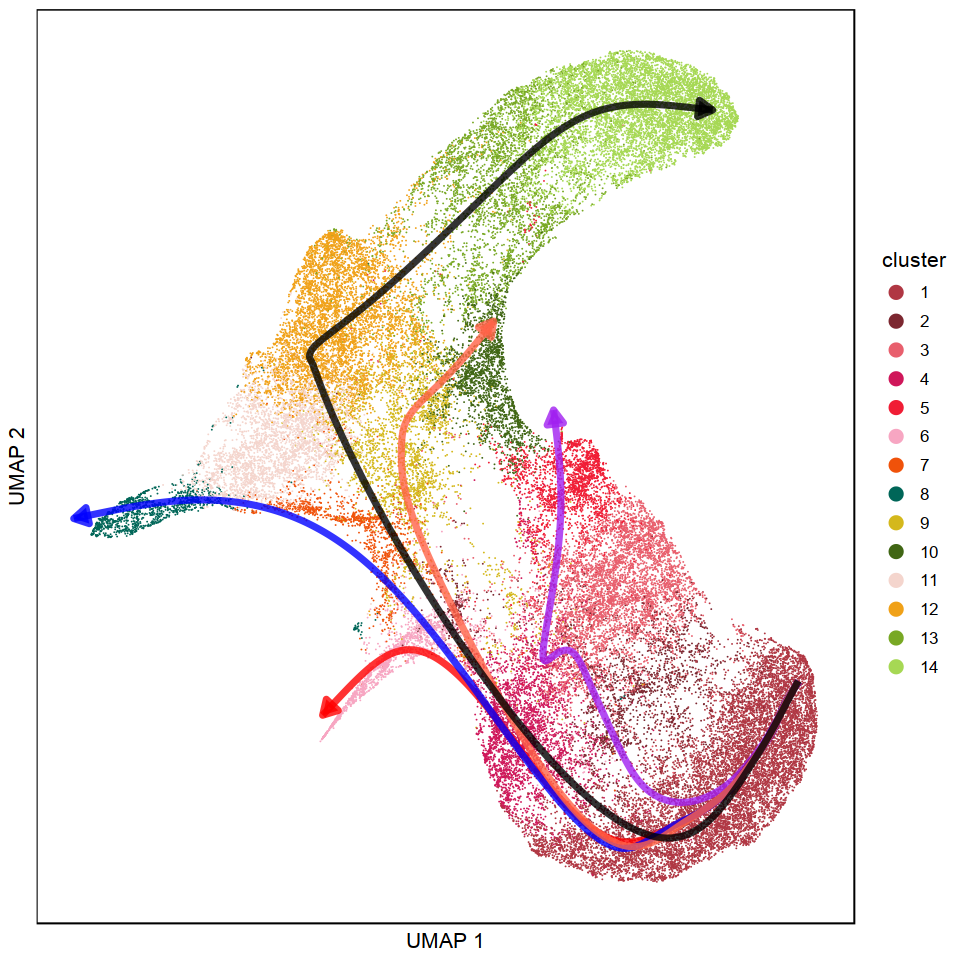

In [29]:
options(repr.plot.width = 8, repr.plot.height = 8)

path_plot <- plot_dimred(metaData$umap1,
           metaData$umap2,
           factor(metaData$cluster_new_id),
                        sz=0.25) + 
scale_color_manual(values=as.character(cluster_config$colour)[order(cluster_config$new_cluster)]) +
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4)))

for (i in seq(length(ALL_PATHS))) {
    selected = which(metaData$cluster_new_id %in% ALL_PATHS[[i]])
    path.df <- data.frame(x = smooth.spline(metaData$umap1[selected][order(pseudotime[selected,"dpt_pseudotime"])], df=200, spar=.9)$y, 
                        y = smooth.spline(metaData$umap2[selected][order(pseudotime[selected,"dpt_pseudotime"])], df=200, spar=.9)$y)
    
    path_plot = path_plot + 
        geom_path(data=path.df, 
                  aes(x, y), 
                  size=1.5,
                  alpha=.8,
                  color=COLS[i], 
                  arrow=arrow(type="closed",
                              length=unit(.02, "npc")))
}

path_plot

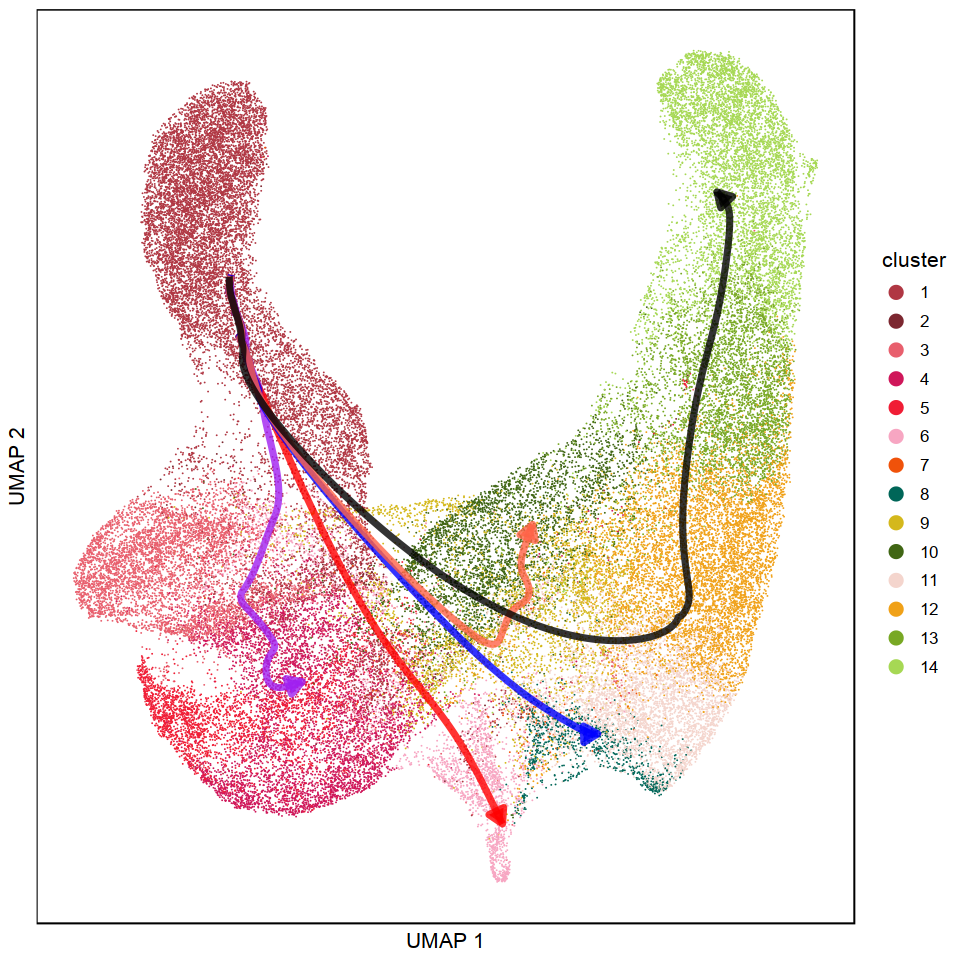

In [30]:
options(repr.plot.width = 8, repr.plot.height = 8)

path_plot <- plot_dimred(rna@reductions$umap@cell.embeddings[,1],
                         rna@reductions$umap@cell.embeddings[,2],
                         factor(atac.rna.label$atac_new_cluster),
                         sz=0.25) + 
scale_color_manual(values=as.character(cluster_config$colour)[order(cluster_config$new_cluster)]) +
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4)))

for (i in seq(length(ALL_PATHS))) {
    atac_selected = which(metaData$cluster_new_id %in% ALL_PATHS[[i]])
    rna_selected = atac2rna_same_cluster_nn[atac_selected, 1]
    
    path.df <- data.frame(x = smooth.spline(rna@reductions$umap@cell.embeddings[,1][rna_selected][order(pseudotime[atac_selected,"dpt_pseudotime"])], 
                                            df=200, spar=.8)$y, 
                        y = smooth.spline(rna@reductions$umap@cell.embeddings[,2][rna_selected][order(pseudotime[atac_selected,"dpt_pseudotime"])], 
                                          df=200, spar=.8)$y)
    
    path_plot = path_plot + 
        geom_path(data=path.df, 
                  aes(x, y), 
                  size=1.5,
                  alpha=.8,
                  color=COLS[i], 
                  arrow=arrow(type="closed",
                              length=unit(.02, "npc")))
}

path_plot

### Genes Along Pseudotime

In [29]:
ATAC_SEL = which(metaData$cluster_new_id %in% c(1,7,11,12,13,14))

In [30]:
# RNA_SEL = atac2rna_nn$nn.idx[ATAC_SEL, 1]
RNA_SEL = atac2rna_same_cluster_nn[ATAC_SEL, 1]

In [31]:
atac.path.df <- data.frame(x = smooth.spline(metaData$umap1[ATAC_SEL][order(pseudotime[ATAC_SEL,"dpt_pseudotime"])], df=200, spar=.9)$y, 
                        y = smooth.spline(metaData$umap2[ATAC_SEL][order(pseudotime[ATAC_SEL,"dpt_pseudotime"])], df=200, spar=.9)$y)

In [111]:
day_config

day colour 
D0  D0  #A61C24
D2  D2  #FF70A6
D4  D4  #D6E82F
D6  D6  #B14AED
D8  D8  #2D3142
D10 D10 #FC7753
D12 D12 #0AABB7
D14 D14 #336699

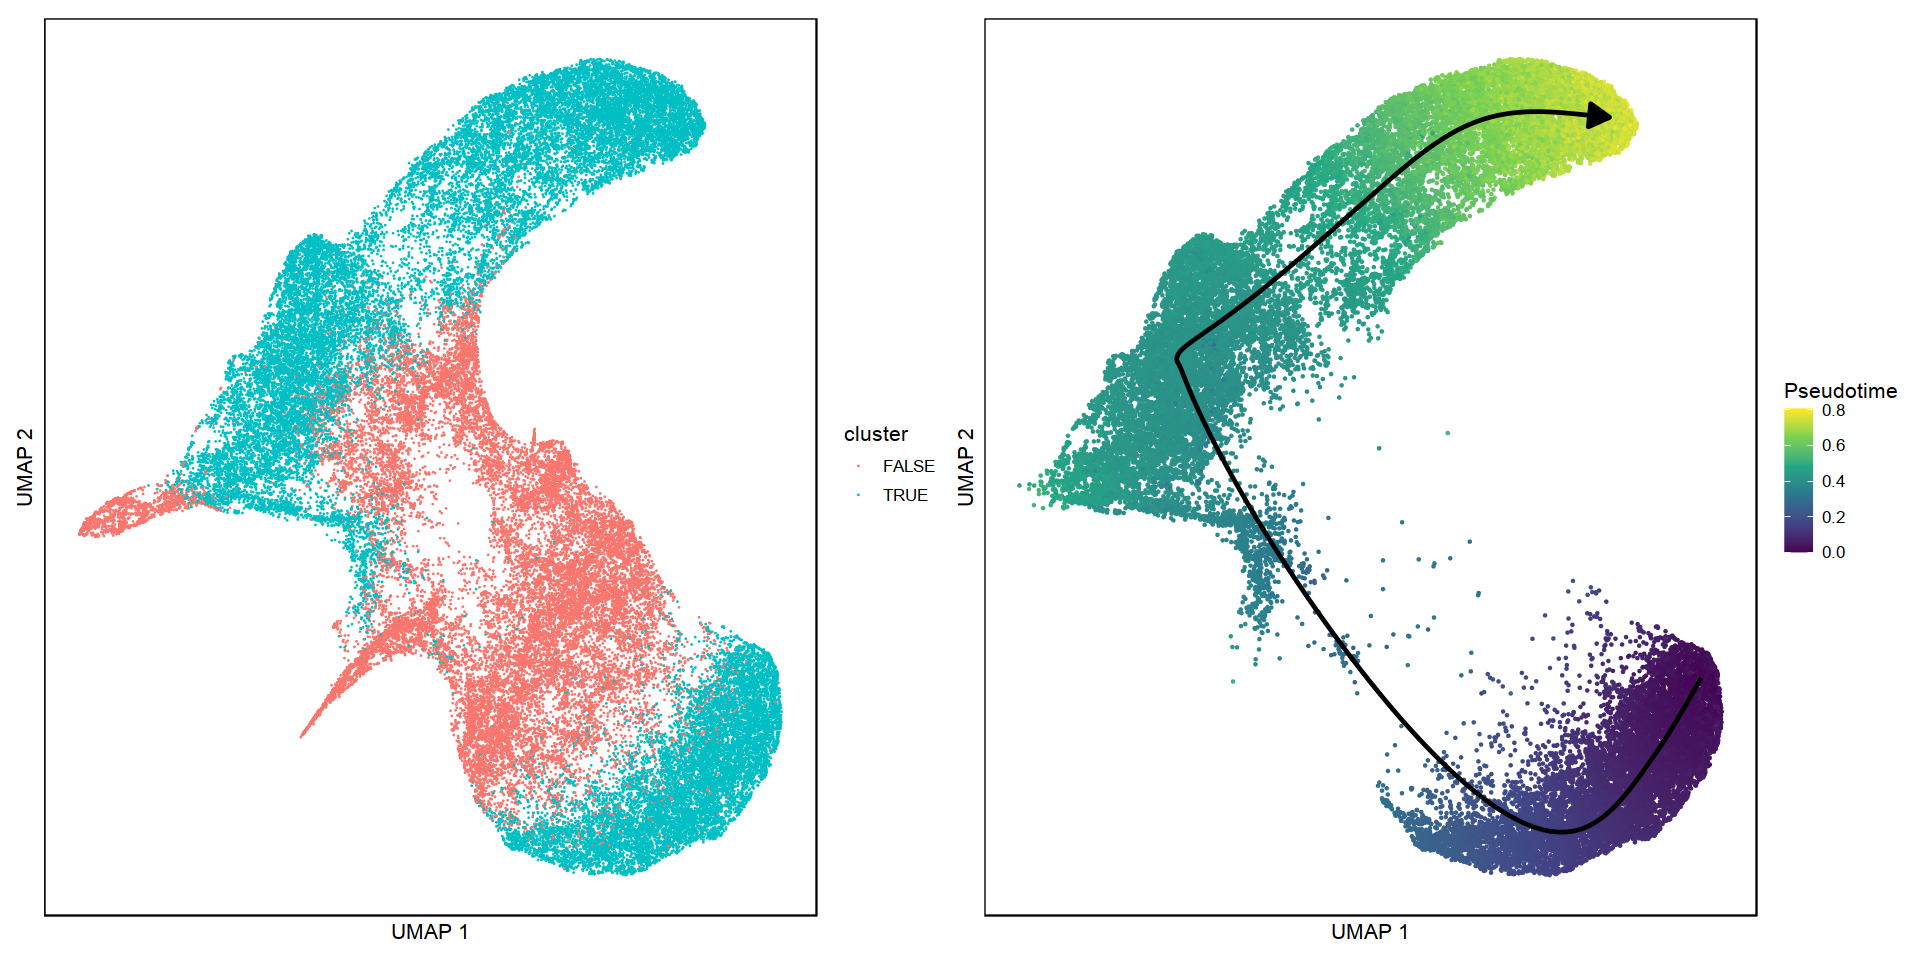

In [243]:
options(repr.plot.width = 16, repr.plot.height = 8)

(plot_dimred(metaData$umap1,
           metaData$umap2,
           seq(nrow(metaData)) %in% ATAC_SEL)) |
(plot_dimred(metaData$umap1[ATAC_SEL],
           metaData$umap2[ATAC_SEL],
           pseudotime[ATAC_SEL,"dpt_pseudotime"],
           sz=1) + 
scale_color_viridis_c(name="Pseudotime") +
geom_path(data=atac.path.df, 
          aes(x, y), 
          size=1,
          color="black", 
          arrow=arrow(type="closed",
                     length=unit(.03, "npc"))))

In [247]:
rna.path.df <- data.frame(x = smooth.spline(rna@reductions$umap@cell.embeddings[,1][RNA_SEL][order(pseudotime[ATAC_SEL,"dpt_pseudotime"])], 
                                            df=200, spar=.8)$y, 
                          y = smooth.spline(rna@reductions$umap@cell.embeddings[,2][RNA_SEL][order(pseudotime[ATAC_SEL,"dpt_pseudotime"])], 
                                            df=200, spar=.8)$y)

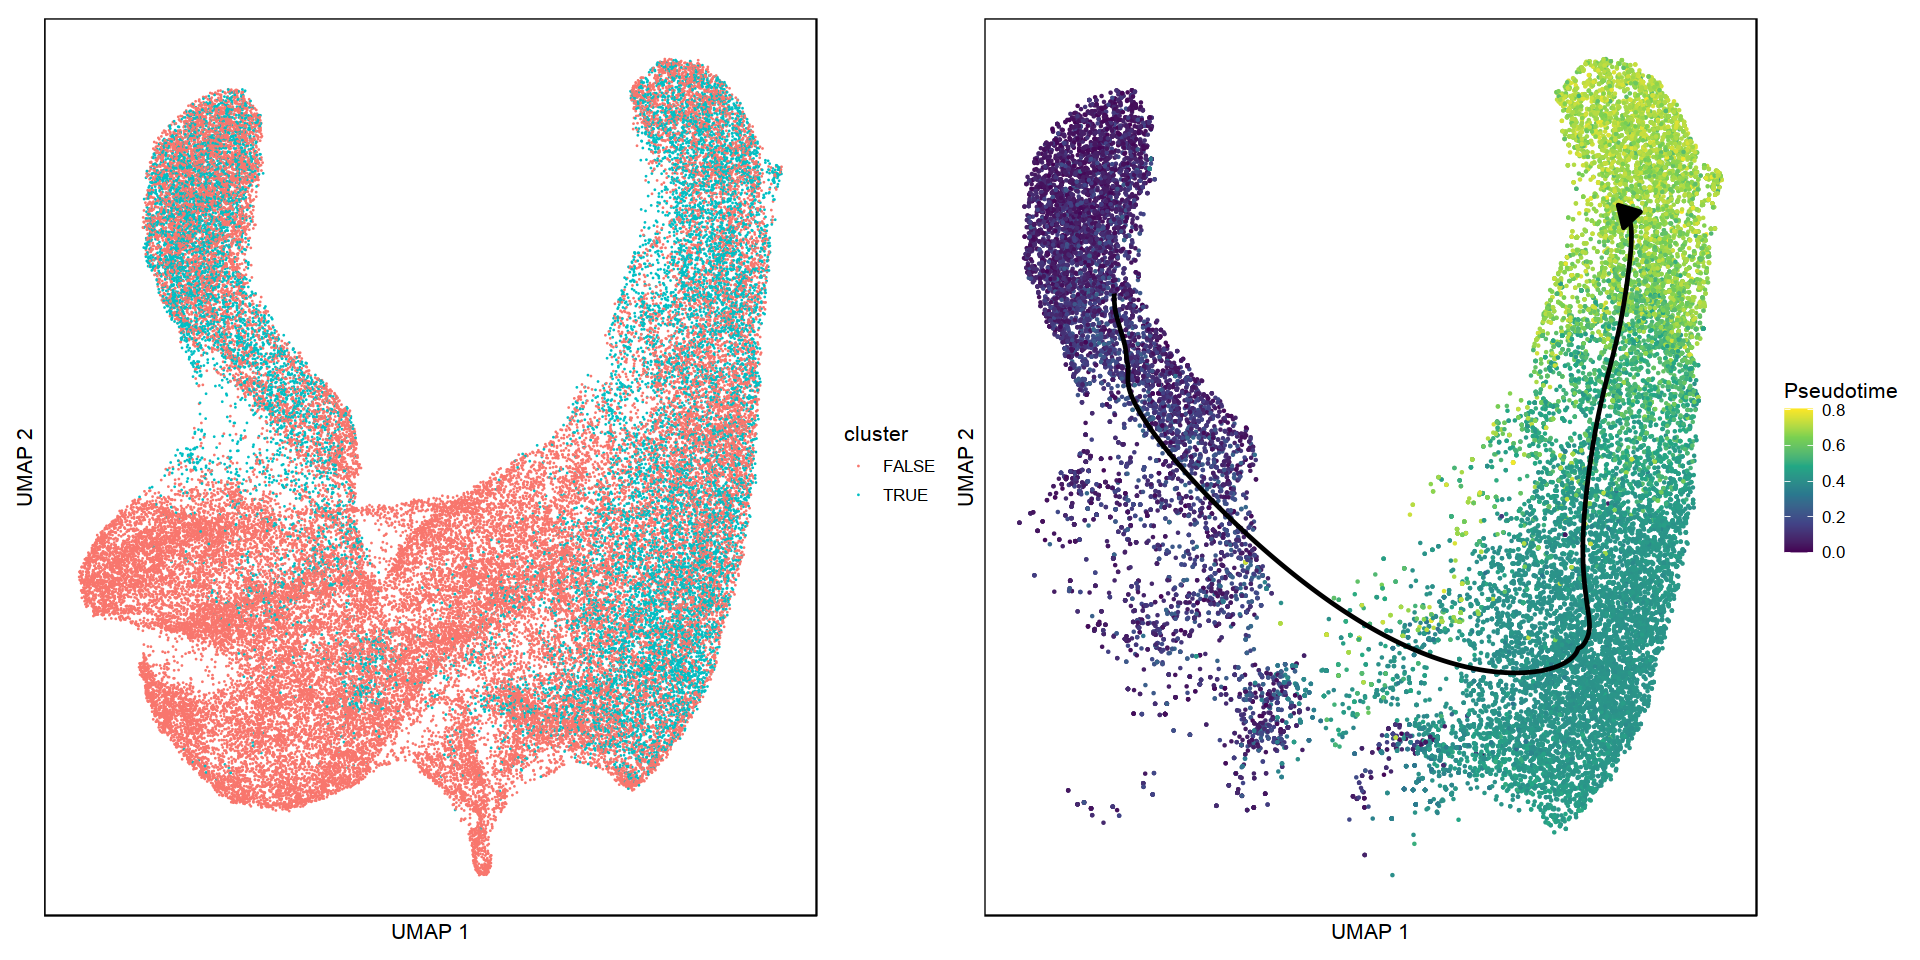

In [245]:
options(repr.plot.width = 16, repr.plot.height = 8)

(plot_dimred(rna@reductions$umap@cell.embeddings[,1],
           rna@reductions$umap@cell.embeddings[,2],
           seq(ncol(rna)) %in% RNA_SEL)) |
(plot_dimred(rna@reductions$umap@cell.embeddings[,1][RNA_SEL],
           rna@reductions$umap@cell.embeddings[,2][RNA_SEL],
           pseudotime[ATAC_SEL,"dpt_pseudotime"],
           sz=1)  + 
scale_color_viridis_c(name="Pseudotime") +
geom_path(data=rna.path.df, 
      aes(x, y), 
      size=1,
      color="black", 
      arrow=arrow(type="closed",
                 length=unit(.03, "npc"))))

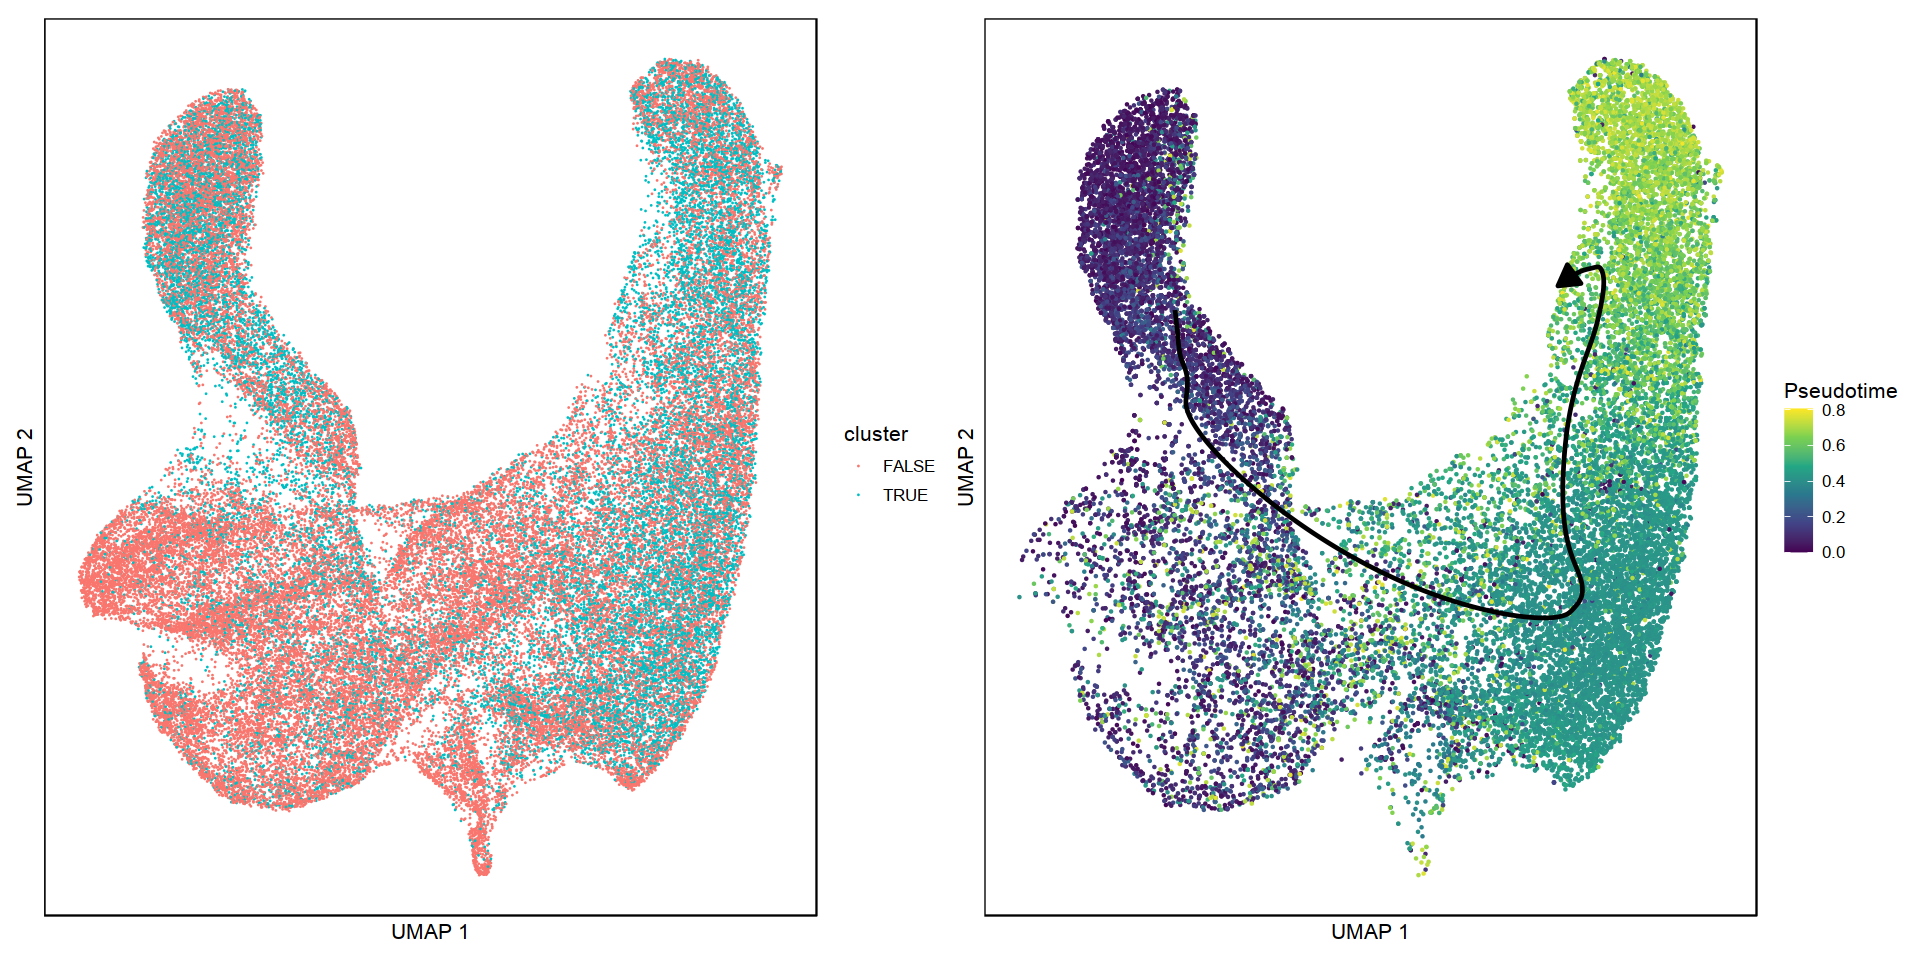

In [248]:
# without NN same cluster constraint
options(repr.plot.width = 16, repr.plot.height = 8)

(plot_dimred(rna@reductions$umap@cell.embeddings[,1],
           rna@reductions$umap@cell.embeddings[,2],
           seq(ncol(rna)) %in% RNA_SEL)) |
(plot_dimred(rna@reductions$umap@cell.embeddings[,1][RNA_SEL],
           rna@reductions$umap@cell.embeddings[,2][RNA_SEL],
           pseudotime[ATAC_SEL,"dpt_pseudotime"],
           sz=1)  + 
scale_color_viridis_c(name="Pseudotime") +
geom_path(data=rna.path.df, 
      aes(x, y), 
      size=1,
      color="black", 
      arrow=arrow(type="closed",
                 length=unit(.03, "npc"))))

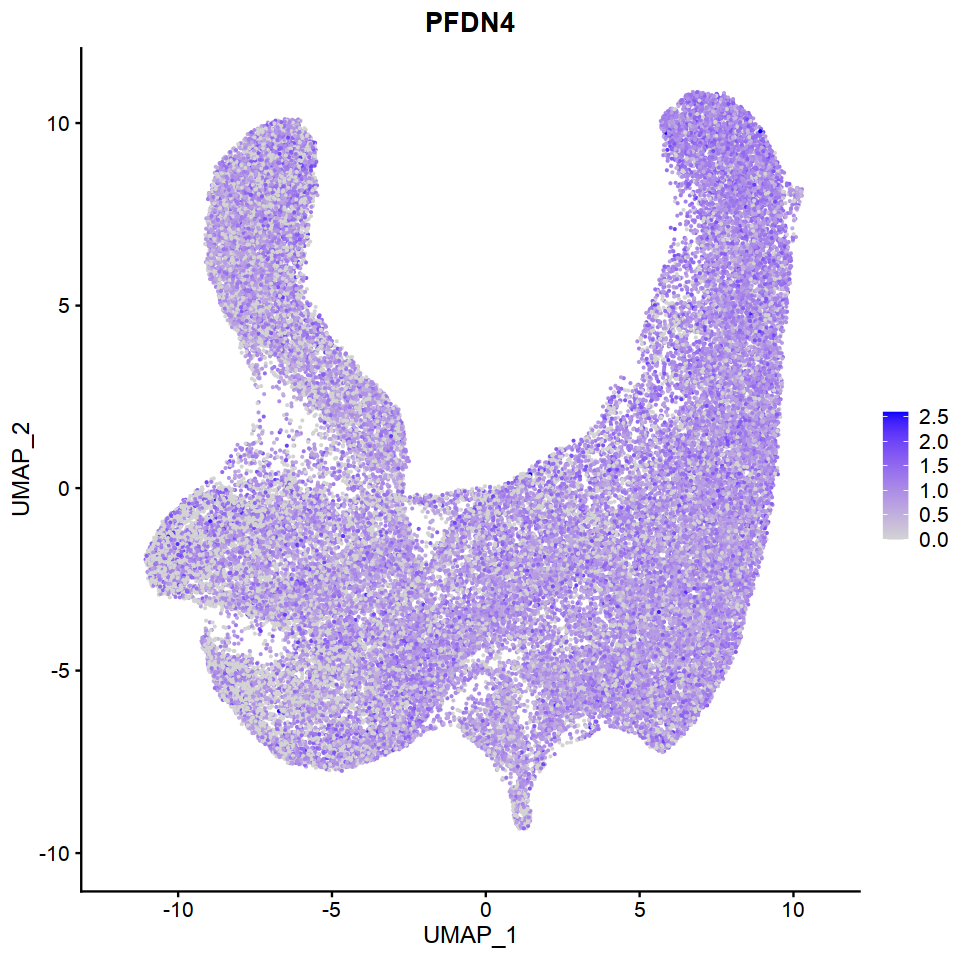

In [114]:
options(repr.plot.width = 8, repr.plot.height = 8)

FeaturePlot(rna, features = c("PFDN4"), reduction = "umap", pt.size = 0.1, combine = FALSE)[[1]]

In [136]:
GENE = "JUNB"
# print(colnames(chromvar)[grep(g, colnames(chromvar), ignore.case = T)])
# TF = colnames(chromvar)[grep(g, colnames(chromvar), ignore.case = T)][1]
# TF

In [146]:
motif = "FOS.JUND_MA1141.1"
colnames(chromvar)[grep(motif, colnames(chromvar), ignore.case=T)]
MOTIF = colnames(chromvar)[grep(motif, colnames(chromvar), ignore.case=T)][1]

[1] "FOS+JUND_MA1141.1"

In [147]:
# temporary till ChromVAR is recalculated
subset_atac_sel = ATAC_SEL[rownames(metaData)[ATAC_SEL] %in% rownames(chromvar)]

# subset_rna_sel = atac2rna_nn$nn.idx[subset_atac_sel, 1] # without same cluster NN constraint
subset_rna_sel = atac2rna_same_cluster_nn[subset_atac_sel, 1]
length(subset_atac_sel)

[1] 32447

In [148]:
cur_expr = rna@assays$RNA@data[GENE, subset_rna_sel]

In [149]:
cur_gene_score = archr_gene_score_mat[GENE, subset_atac_sel]

In [150]:
cur_chromvar = chromvar[subset_atac_sel,MOTIF]

In [151]:
cur_pseudotime = pseudotime[subset_atac_sel,"dpt_pseudotime"]

In [152]:
EXPR_vals = cur_expr[order(cur_pseudotime)]

# smoothed min-max norm
smoothed = predict(gam(y ~ s(x, bs="cs"), 
                       data = data.frame(x=seq(length(EXPR_vals)), #sort(cur_pseudotime)
                                         y=EXPR_vals)))

EXPR_vals = EXPR_vals - min(smoothed)
EXPR_vals = EXPR_vals/(max(smoothed)-min(smoothed))

In [153]:
GS_vals = log2(1+cur_gene_score[order(pseudotime[subset_atac_sel,"dpt_pseudotime"])])

# smoothed min-max norm
smoothed = predict(gam(y ~ s(x, bs="cs"), 
                       data = data.frame(x=seq(length(EXPR_vals)), #sort(cur_pseudotime)
                                         y=GS_vals)))

GS_vals = GS_vals - min(smoothed)
GS_vals = GS_vals/(max(smoothed)-min(smoothed))

In [154]:
CV_vals = cur_chromvar[order(pseudotime[subset_atac_sel,"dpt_pseudotime"])]

# smoothed min-max norm
smoothed = predict(gam(y ~ s(x, bs="cs"), 
                       data = data.frame(x=seq(length(EXPR_vals)), #sort(cur_pseudotime)
                                         y=CV_vals)))

CV_vals = CV_vals - min(smoothed)
CV_vals = CV_vals/(max(smoothed)-min(smoothed))

In [155]:
EXPR_df = data.frame(x=seq(length(EXPR_vals)), #sort(cur_pseudotime), 
                    y=EXPR_vals,
                    z="Expression")
GS_df = data.frame(x=seq(length(EXPR_vals)), #sort(cur_pseudotime)
                  y=GS_vals,
                  z="Gene Score")
CV_df = data.frame(x=seq(length(EXPR_vals)), #sort(cur_pseudotime)
                  y=CV_vals,
                  z="ChromVAR Score")

plot_df = rbind(EXPR_df, GS_df, CV_df)
# plot_df = rbind(EXPR_df, GS_df)

# shuffle
plot_df = plot_df[sample(nrow(plot_df)), ]

In [156]:
length(cur_gene_score)

[1] 32447

In [157]:
head(cur_gene_score)

D0_AACGCGAGAAGGACCA D0_AACGCGCTGTCTGTGA D0_ACCTATGGACTCGATA D0_ACGCAGAGATAACCCA 
              1.595               0.000               2.043               1.959 
D0_ACTCGCTACTTGTGAC D0_AGACTACTGGCAGTTT 
              0.000               0.000

In [158]:
head(cur_chromvar)

[1] 0.02494523 0.20131923 0.16806740 0.10492714 0.16184926 0.11908112

In [159]:
tail(names(cur_gene_score))

[1] "D8_TTTCTGAACTATGACC" "D8_TTTGACGGAAGACTTC" "D8_TTTGACGGATTAGCTG"
[4] "D8_TTTGCGGCTGCACCCA" "D8_TTTGGGAACATCCGTA" "D8_TTTGGGAACTCGTAAC"

In [160]:
head(metaData)

barcode          sample umap1    umap2     cluster
D0_AACGCGAGAAGGACCA AACGCGAGAAGGACCA D0     8.373301 -4.292619 5      
D0_AACGCGCTGTCTGTGA AACGCGCTGTCTGTGA D0     2.033609 -7.860645 5      
D0_ACCTATGGACTCGATA ACCTATGGACTCGATA D0     3.093788 -7.469210 5      
D0_ACGCAGAGATAACCCA ACGCAGAGATAACCCA D0     6.001364 -7.523576 5      
D0_ACTCGCTACTTGTGAC ACTCGCTACTTGTGAC D0     3.343237 -8.114589 5      
D0_AGACTACTGGCAGTTT AGACTACTGGCAGTTT D0     7.112911 -6.751318 5      
                    cells               cluster_new_id
D0_AACGCGAGAAGGACCA D0_AACGCGAGAAGGACCA 1             
D0_AACGCGCTGTCTGTGA D0_AACGCGCTGTCTGTGA 1             
D0_ACCTATGGACTCGATA D0_ACCTATGGACTCGATA 1             
D0_ACGCAGAGATAACCCA D0_ACGCAGAGATAACCCA 1             
D0_ACTCGCTACTTGTGAC D0_ACTCGCTACTTGTGAC 1             
D0_AGACTACTGGCAGTTT D0_AGACTACTGGCAGTTT 1

In [161]:
get_median_day_every_n <- function(days, n=100) {
    rounded_length = floor(length(days)/n)*n

    days_numeric = as.numeric(lapply(strsplit(as.character(days), "D"), "[[", 2))[1:rounded_length]

    averaged_days = colMedians(matrix(days_numeric, n))

    averaged_days = floor(averaged_days/2)*2 # when medians are odd

    averaged_days = paste("D", averaged_days, sep="")    
    
    averaged_days
}

In [132]:
atac_averaged_days = get_median_day_every_n(metaData[subset_atac_sel[order(pseudotime[subset_atac_sel,"dpt_pseudotime"])], "sample"], n=100)
rna_averaged_days = get_median_day_every_n(rna$sample[subset_rna_sel[order(pseudotime[subset_atac_sel,"dpt_pseudotime"])]], n=100)

In [133]:
table(atac_averaged_days)
table(rna_averaged_days)

atac_averaged_days
 D0 D10 D12 D14  D2  D4  D6  D8 
109   6   8  97  11   3  70  20 

rna_averaged_days
 D0 D10 D12 D14  D2  D4  D6  D8 
106  18  35  65   3   9  43  45 

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



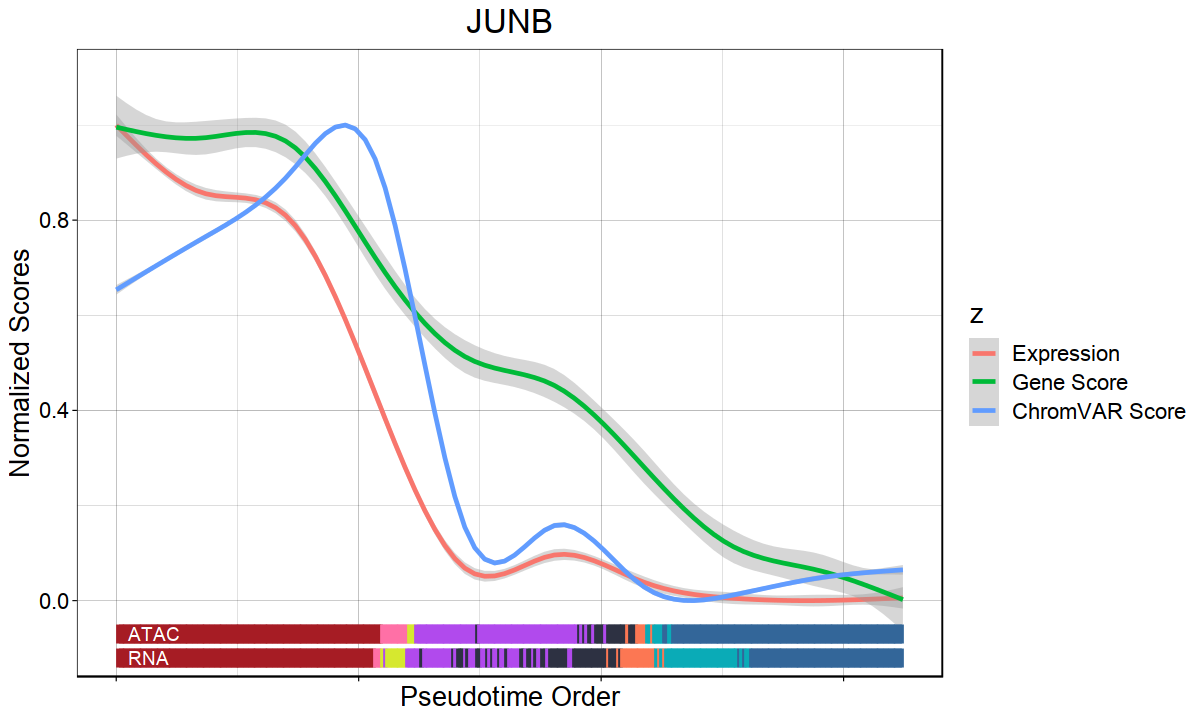

In [162]:
options(repr.plot.width = 10, repr.plot.height = 6)

integrated_plot <- ggplot(plot_df) + 
# geom_point(aes (x=x,y=y,colour=z,group=z), stroke=0, size=1, alpha=0.1) +
geom_smooth(aes(x=x,y=y,colour=z, group=z)) +
xlab("Pseudotime Order") +
ylab("Normalized Scores") +
ggtitle(GENE) +
coord_cartesian(ylim=c(-0.1,1.1)) +
theme_linedraw() +
theme(plot.title = element_text(hjust = 0.5),
      axis.text.x = element_blank(),
     text = element_text(size=16))

for (i in seq(1,length(atac_averaged_days))) {
    integrated_plot = integrated_plot + annotate("segment", x=i*ROUND_EVERY, xend=i*ROUND_EVERY,
                                                 y= -0.05, yend=-0.09, size=1,
                                                 color=day_config[atac_averaged_days[i], "colour"])
}

for (i in seq(1,length(rna_averaged_days))) {
    integrated_plot = integrated_plot + annotate("segment", x=i*ROUND_EVERY, xend=i*ROUND_EVERY,
                                                 y= -0.1, yend=-0.14, size=1,
                                                 color=day_config[rna_averaged_days[i], "colour"])
}

integrated_plot = integrated_plot + annotate("text", x=500, y=-0.07, hjust=0, label="ATAC", color="white")
integrated_plot = integrated_plot + annotate("text", x=500, y=-0.12, hjust=0, label="RNA", color="white")

# wrap_plots(integrated_plot, day_bar, heights=c(5,1))
integrated_plot

In [130]:
ggsave("./tmp.png", integrated_plot, width=10,height=6)

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



### Expression vs Gene Score Correlations

In [124]:
gboth = intersect(rownames(rna), rownames(archr_gene_score_mat))

In [125]:
A = rna@assays$RNA@counts[gboth, RNA_SEL][, order(pseudotime[ATAC_SEL,"dpt_pseudotime"])]
B = archr_gene_score_mat[gboth, ATAC_SEL][, order(pseudotime[ATAC_SEL,"dpt_pseudotime"])]

In [126]:
create_sum_matrix <- function(n, r) {
  suppressWarnings(matrix(c(rep(1, r), rep(0, n)), n, n/r))
}

In [127]:
# sum every 100 along pseudotime
aggA = A[,1:31200] %*% create_sum_matrix(31200, 100)
aggB = B[,1:31200] %*% create_sum_matrix(31200, 100)
aggA = as.matrix(aggA)
aggB = as.matrix(aggB)

In [128]:
library(DESeq2)

In [129]:
# DESeq2 normalize
normaggA = log2(1+t(t(aggA)/estimateSizeFactorsForMatrix(aggA)))
normaggB = log2(1+t(t(aggB)/estimateSizeFactorsForMatrix(aggB)))

In [153]:
cA <-normaggA - rowMeans(normaggA)
cB <- normaggB - rowMeans(normaggB)
sA <- sqrt(rowMeans(cA^2))
sB <- sqrt(rowMeans(cB^2))

corrs = rowMeans(cA * cB) / (sA * sB)

In [154]:
corrs["CTCF"]

CTCF 
-0.4323856

In [165]:
sum(corrs< -0.4)

[1] 278

In [159]:
corrs["JAKMIP2"]

JAKMIP2 
0.04604792

In [160]:
corrs = corrs[!is.na(corrs)]

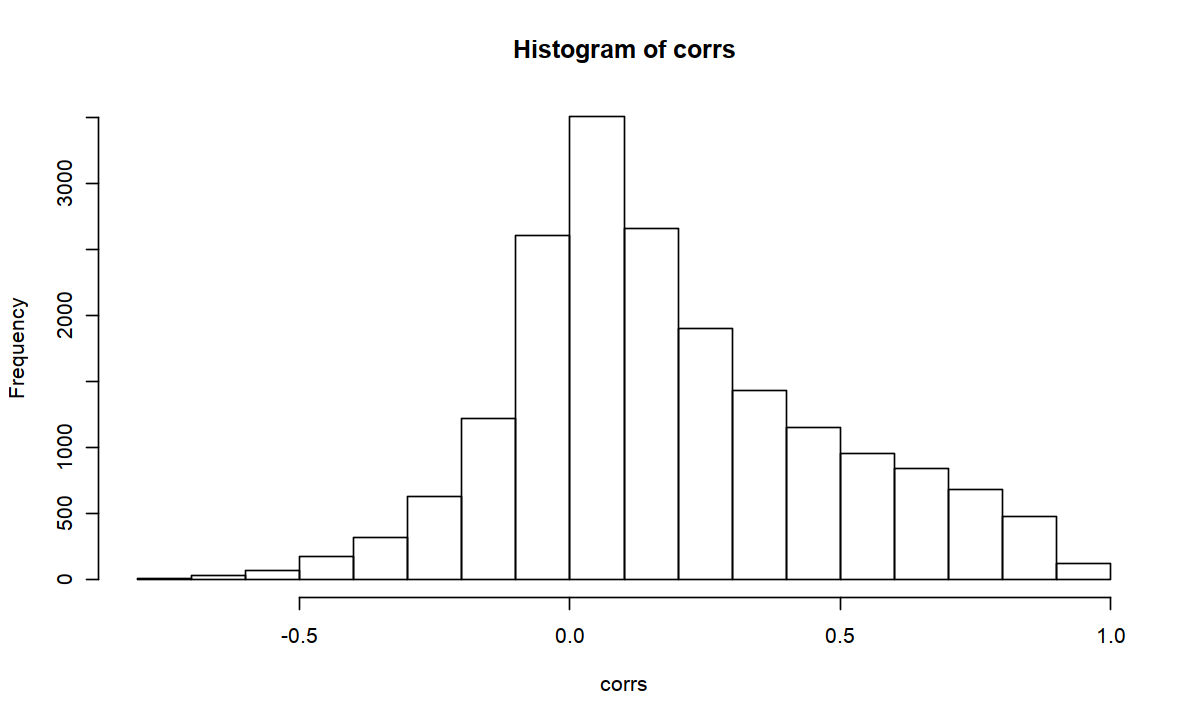

In [161]:
hist(corrs)

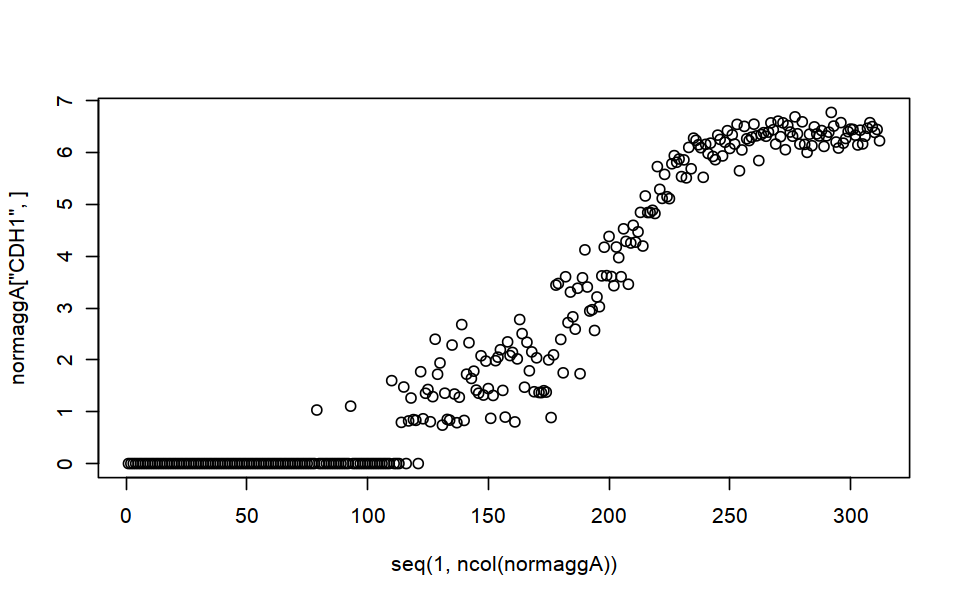

In [205]:
plot(seq(1,ncol(normaggA)), normaggA["CDH1", ])

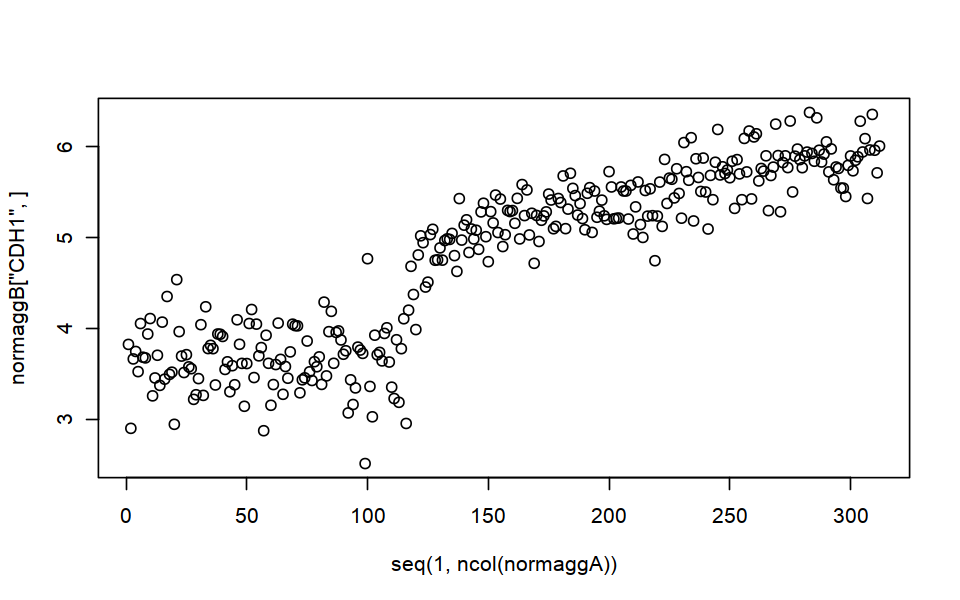

In [206]:
plot(seq(1,ncol(normaggA)), normaggB["CDH1", ])

In [59]:
corrs[grep("SOX2", names(corrs))]

SOX2-OT      SOX2     QSOX2 SOX21-AS1     SOX21 
0.8446813 0.1198320 0.2389824 0.8893761 0.8807335

In [60]:
corrs[(order(corrs))][1:50]

NDUFS4    LINC00545         RPL3        CORO7        CMSS1       ECHDC2 
  -0.7628090   -0.7518200   -0.7377801   -0.7321128   -0.7317497   -0.7176144 
         MYC      MMP24OS       TBC1D5       CAMTA1        CDCA4         CDT1 
  -0.6963681   -0.6957105   -0.6952842   -0.6943604   -0.6832910   -0.6777123 
      GTF3C1         SNX5      POLDIP3        MRPL4         BOP1       COMMD1 
  -0.6718864   -0.6718576   -0.6622573   -0.6571171   -0.6527374   -0.6500436 
       GLRX5       DNAJC1         SARS        GSTO2        NOP53        SUMF1 
  -0.6473266   -0.6465457   -0.6441155   -0.6427319   -0.6383480   -0.6373200 
        MIDN       RFPL4B       SMIM19     HOXB-AS1        WDR74         BRI3 
  -0.6351437   -0.6342489   -0.6327911   -0.6318833   -0.6310818   -0.6222061 
      SNRPD3         IDNK       PRKAB2       EXOSC7        CNTLN        UBE2S 
  -0.6218639   -0.6174270   -0.6146458   -0.6057177   -0.6029681   -0.5995108 
    C12orf57       SNHG16        SRRM1         LIG3     ARHGAP26 TRAF3IP2-AS1 
  -0.5993593   -0.5980422   -0.5979046   -0.5924096   -0.5892945   -0.5888273 
       MED15         RCN1       PITPNB       DLGAP4         CMIP     KIAA2013 
  -0.5796570   -0.5757186   -0.5751721   -0.5745074   -0.5719788   -0.5707852 
      SEC23A       MPV17L 
  -0.5704394   -0.5699397

In [61]:
names(corrs[(order(corrs))][1:200])[grep("^RP", names(corrs[(order(corrs))][1:200]))]

[1] "RPL3"   "RPS9"   "RPS27"  "RPS16"  "RPLP2"  "RPL7"   "RPL37A"

In [ ]:
write.table(names(corrs[(order(corrs))][1:100])[normaggA[names(corrs[(order(corrs))][1:100]), 312]>normaggA[names(corrs[(order(corrs))][1:100]), 1]], 
            "tmp.txt", quote=F, row.names=F, col.names=F)

In [92]:
sum(normaggA[names(corrs[(order(corrs))][1:100]), 312]> normaggA[names(corrs[(order(corrs))][1:100]), 1])

[1] 71

In [71]:
corrs[rev(order(corrs))][1:10]

COL6A3       FOS     THBS1    SEMA6A      EGR1    COL6A2     GREM1    COL1A1 
0.9725415 0.9669856 0.9657313 0.9636175 0.9625606 0.9625132 0.9618802 0.9609644 
    LOXL2       TNC 
0.9599441 0.9581315

In [563]:
max(corrs, na.rm = T)

[1] 0.5067538

**Chatacterizing Genes with Negative Correlation with Gene Score**

In [166]:
gene_sets = list()
for (i in seq(10)) {
    gene_sets[[i]] = as.character(read.table(sprintf("../20200828_RNA_Seurat/gene_sets/20201012_tmp_gridmap_znorm_n10/idx%d.txt", i))$V1)
}

In [203]:
head(rev(sort(corrs[gene_sets[[2]]])), 20)

NLRP2      CDH8     NLRP7     GCNT2    PRDM14     ZFP42     FGFR2    UNC93A 
0.9451872 0.9385996 0.9330507 0.9304335 0.9230460 0.9184760 0.9157215 0.9106322 
    CHODL      DAB1    ZNF208      FGF4     SFRP2       SP8    SUCLA2 LINC01108 
0.9092018 0.9086671 0.9068033 0.9033758 0.9007033 0.8979860 0.8933441 0.8893471 
     MYCN    ZNF486      MMP9      PDPN 
0.8864058 0.8860590 0.8855954 0.8845929

In [167]:
gene_set_sizes = unlist(lapply(gene_sets, length))
gene_set_sizes

[1] 324 506 554 422 329 212 657 345 251 445

In [168]:
head(gene_sets[[1]])

[1] "HES4"    "ISG15"   "TNFRSF4" "MMP23B"  "GPR153"  "TNFRSF9"

In [169]:
head(corrs)

FAM87B   LINC01128   LINC00115      FAM41C   LINC02593      SAMD11 
-0.03728296  0.03014009 -0.09488130  0.06238444  0.34970011  0.66886722

In [170]:
top_pos_genes = names(corrs)[corrs >0.4]
top_neg_genes = names(corrs)[corrs < -0.4]

# top_pos_genes = p2g_df[rev(order(p2g_df$Correlation)), "gene"][1:10000]
# top_neg_genes = p2g_df[order(p2g_df$Correlation), "gene"][1:10000]

In [171]:
pos_tot = c()
neg_tot = c()

for (i in seq(10)){
    pos_tot = c(pos_tot, sum(top_pos_genes %in% gene_sets[[i]]))
    neg_tot = c(neg_tot, sum(top_neg_genes %in% gene_sets[[i]]))
}

In [181]:
write.table(top_neg_genes, 'tmp.txt', quote=F, row.names=F, col.names=F)

In [182]:
pos_tot
neg_tot

[1] 111 296 415 193  57  52 404  35 144 161

[1]  2  8  1  2  1  3 17 18  1  5

In [173]:
pos_tot/sum(pos_tot)

[1] 0.05942184 0.15845824 0.22216274 0.10331906 0.03051392 0.02783726
 [7] 0.21627409 0.01873662 0.07708779 0.08618844

In [174]:
neg_tot/sum(neg_tot)

[1] 0.03448276 0.13793103 0.01724138 0.03448276 0.01724138 0.05172414
 [7] 0.29310345 0.31034483 0.01724138 0.08620690

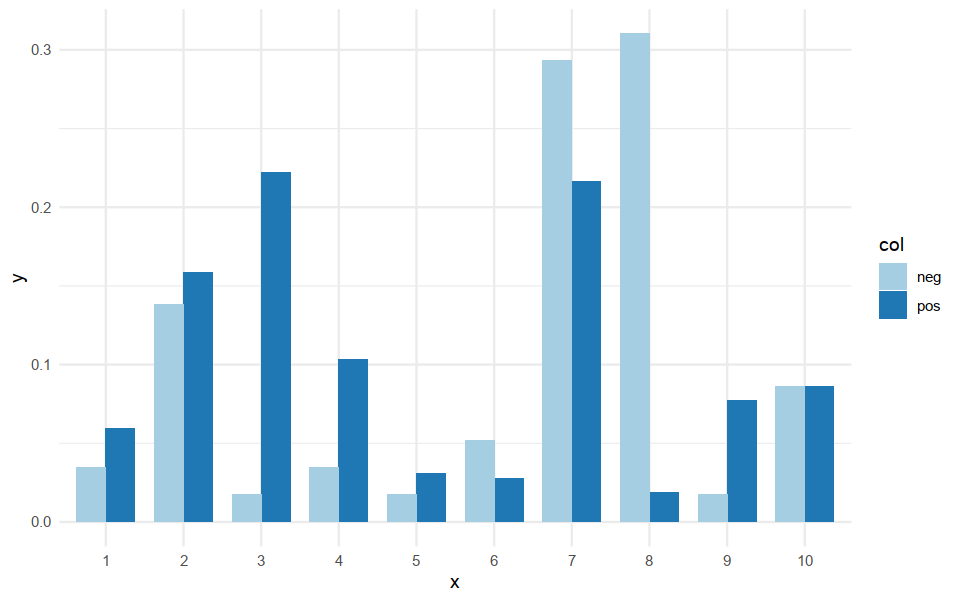

In [176]:
options(repr.plot.width = 8, repr.plot.height = 5)

ggplot(data.frame(x=factor(rep(seq(10),2)),
                 y=c(pos_tot/sum(pos_tot), neg_tot/sum(neg_tot)),
                 col = c(rep("pos", 10), rep("neg", 10))),
      aes(x=x,y=y, fill=col)) +
geom_bar(stat="identity", width=0.75, position=position_dodge()) +
  scale_fill_brewer(palette="Paired")+
  theme_minimal()

In [177]:
pos_tot_adjust = 100*pos_tot/gene_set_sizes
neg_tot_adjust = 100*neg_tot/gene_set_sizes

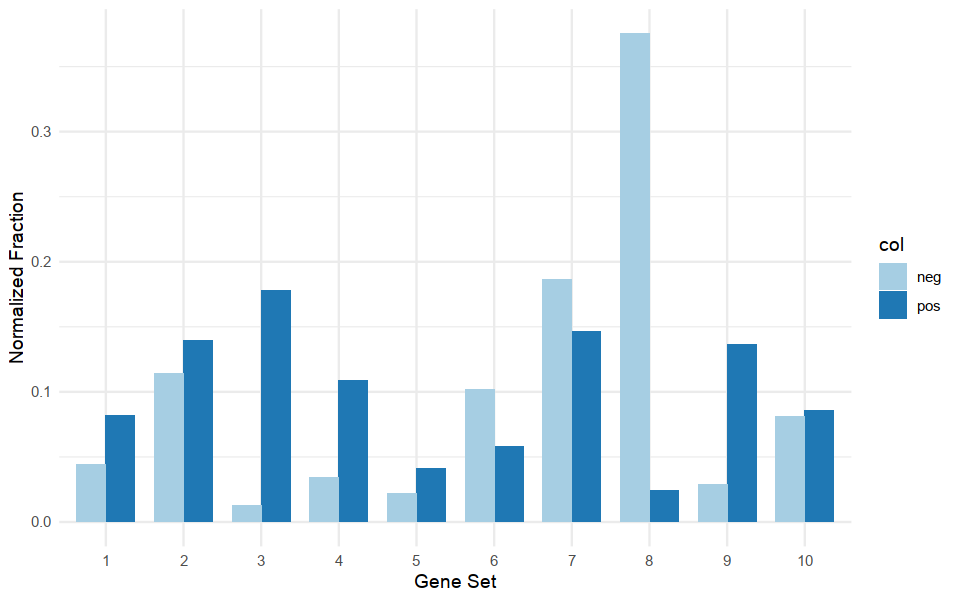

In [399]:
options(repr.plot.width = 8, repr.plot.height = 5)

ggplot(data.frame(x=factor(rep(seq(10),2)),
                 y=c(pos_tot_adjust/sum(pos_tot_adjust), neg_tot_adjust/sum(neg_tot_adjust)),
                 col = c(rep("pos", 10), rep("neg", 10))),
      aes(x=x,y=y, fill=col)) +
xlab("Gene Set") + ylab("Normalized Fraction") +
geom_bar(stat="identity", width=0.75, position=position_dodge()) +
  scale_fill_brewer(palette="Paired")+
  theme_minimal()

### Gene Score/Expression Lead vs Lag

In [207]:
genes_of_interest = as.vector(read.table("../20200828_RNA_Seurat/gene_sets/20201012_tmp_gridmap_znorm_n10/idx2.txt")$V1)
# genes_of_interest = c(genes_of_interest,
#                       as.vector(read.table("../20200828_RNA_Seurat/gene_sets/20201012_tmp_gridmap_znorm_n10/idx7.txt")$V1))
length(genes_of_interest)

# available gene score
genes_of_interest = genes_of_interest[genes_of_interest %in% rownames(archr_gene_score_mat)]
length(genes_of_interest)

# intersect with top variable genes (top 2000 by default, or calculate if more required)
genes_of_interest = genes_of_interest[genes_of_interest %in% VariableFeatures(rna)]
# genes_of_interest = genes_of_interest[genes_of_interest %in% VariableFeatures(FindVariableFeatures(rna, nfeatures = 5000))]
length(genes_of_interest)

[1] 506

[1] 448

[1] 151

In [208]:
# genes_of_interest = c("CDH1", "NANOG")

In [221]:
genes_of_interest[grep("DPPA", genes_of_interest)]

[1] "DPPA2" "DPPA5" "DPPA3"

Smooth gene scores and expression value along pseudotime.

In [210]:
cur_pseudotime = pseudotime[ATAC_SEL,"dpt_pseudotime"]

smoothed_expr_mat = matrix(0, length(genes_of_interest), length(cur_pseudotime))
smoothed_gs_mat = matrix(0, length(genes_of_interest), length(cur_pseudotime))

rownames(smoothed_expr_mat) = genes_of_interest
rownames(smoothed_gs_mat) = genes_of_interest

In [211]:
for (gene in genes_of_interest) {
    cur_expr = rna@assays$RNA@data[gene, RNA_SEL][order(cur_pseudotime)]
    cur_gene_score = log2(1+archr_gene_score_mat[gene, ATAC_SEL])[order(cur_pseudotime)]
    
    smoothed_expr = predict(gam(y ~ s(x, bs="cs"), 
                       data = data.frame(x=seq(length(cur_expr)), 
                                         y=cur_expr)))
    
    smoothed_gs = predict(gam(y ~ s(x, bs="cs"), 
                       data = data.frame(x=seq(length(cur_gene_score)),
                                         y=cur_gene_score)))
    
    # min-max normlize
    smoothed_expr = (smoothed_expr - min(smoothed_expr))/(max(smoothed_expr)  - min(smoothed_expr))
    smoothed_gs = (smoothed_gs - min(smoothed_gs))/(max(smoothed_gs)  - min(smoothed_gs))
    
    smoothed_expr_mat[gene,] = smoothed_expr
    smoothed_gs_mat[gene,] = smoothed_gs
}

In [215]:
# from aggregated cells and DESeq2 normalization-- ends up looking different
# e.g. a lot of gene scores and expr values seem to reduce towards the end
# this could follow from the fact that more genes are expressed but normalization
# makes total the same for all cells
smoothed_expr_agg_mat = matrix(0, length(genes_of_interest), ncol(normaggA))
smoothed_gs_agg_mat = matrix(0, length(genes_of_interest), ncol(normaggB))

rownames(smoothed_expr_agg_mat) = genes_of_interest
rownames(smoothed_gs_agg_mat) = genes_of_interest

In [216]:
for (gene in genes_of_interest) {
    cur_expr = normaggA[gene,]
    cur_gene_score = normaggB[gene,]
    
    smoothed_expr = predict(gam(y ~ s(x, bs="cs"), 
                       data = data.frame(x=seq(length(cur_expr)), 
                                         y=cur_expr)))
    
    smoothed_gs = predict(gam(y ~ s(x, bs="cs"), 
                       data = data.frame(x=seq(length(cur_gene_score)),
                                         y=cur_gene_score)))
    
    # min-max normlize
    smoothed_expr = (smoothed_expr - min(smoothed_expr))/(max(smoothed_expr)  - min(smoothed_expr))
    smoothed_gs = (smoothed_gs - min(smoothed_gs))/(max(smoothed_gs)  - min(smoothed_gs))
    
    smoothed_expr_agg_mat[gene,] = smoothed_expr
    smoothed_gs_agg_mat[gene,] = smoothed_gs
}

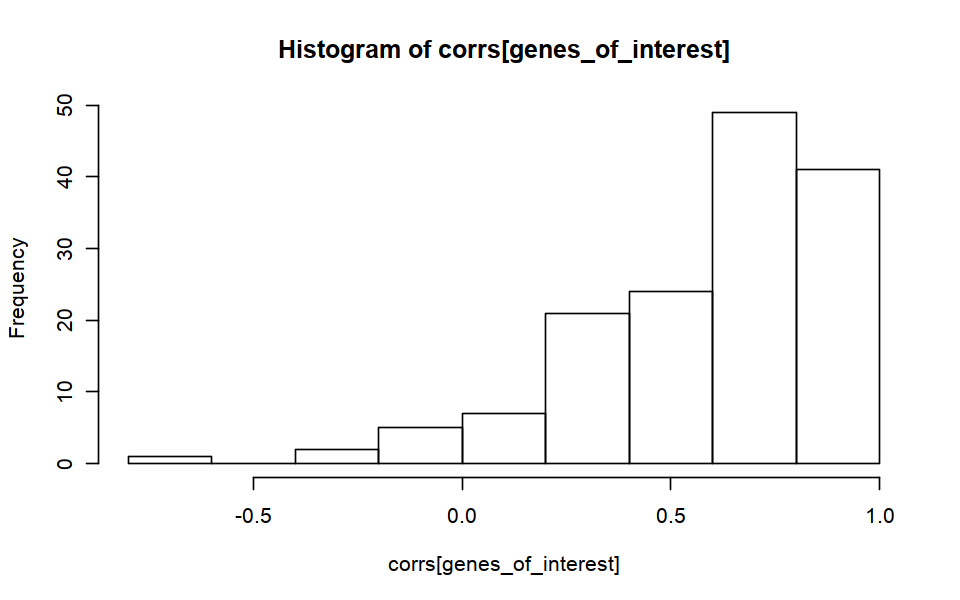

In [217]:
hist(corrs[genes_of_interest])

In [340]:
# take genes with positive correlation for lead vs lag
CORR_CUTOFF = 0.4

genes = genes_of_interest[corrs[genes_of_interest]>CORR_CUTOFF]
genes = genes[!is.na(genes)]
length(genes)

genes[rev(order(rowMeans(smoothed_gs_mat - smoothed_expr_mat)[genes]))][1:20]

[1] 114

[1] "VCX"       "PTH1R"     "LINC01356" "ACTA1"     "RFPL2"     "DACT1"    
 [7] "LINC01405" "CRABP1"    "ADAM18"    "TERF1"     "ERVH48-1"  "SUSD3"    
[13] "FXYD4"     "FAM151A"   "LRRC6"     "TACSTD2"   "BRDT"      "CLEC7A"   
[19] "ALPG"      "FAM189A2"

In [139]:
# gs_minus_expr = smoothed_gs_mat - smoothed_expr_mat
gs_minus_expr = smoothed_gs_agg_mat - smoothed_expr_agg_mat 
# using agg mats seems to make more sense, though for some cases expression leads gene score

gs_minus_expr_clipped = gs_minus_expr
# gs_minus_expr_clipped[gs_minus_expr_clipped<0] = 0

# lead_scores = rowMeans(gs_minus_expr)
lead_scores = rowMeans(gs_minus_expr_clipped)

genes[(order(lead_scores[genes]))]

[1] "NANOG" "CDH1"

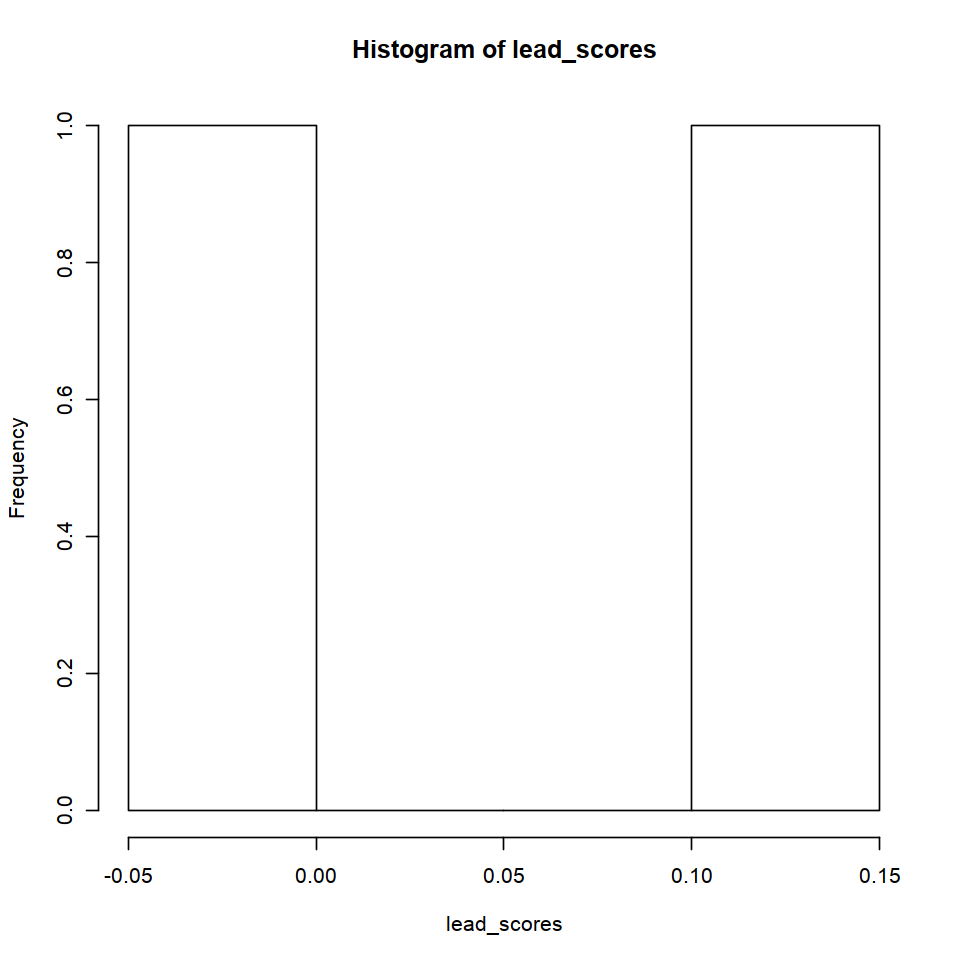

In [140]:
hist(lead_scores)

In [369]:
GENE = "DPPA3"

EXPR_df = data.frame(x=seq(ncol(smoothed_expr_mat)), #sort(cur_pseudotime), 
                    y=smoothed_expr_mat[GENE,],
                    z="Expression")
GS_df = data.frame(x=seq(ncol(smoothed_expr_mat)), #sort(cur_pseudotime)
                  y=smoothed_gs_mat[GENE,],
                  z="Gene Score")

plot_df = rbind(EXPR_df, GS_df)
# plot_df = rbind(EXPR_df, GS_df)

# shuffle
plot_df = plot_df[sample(nrow(plot_df)), ]

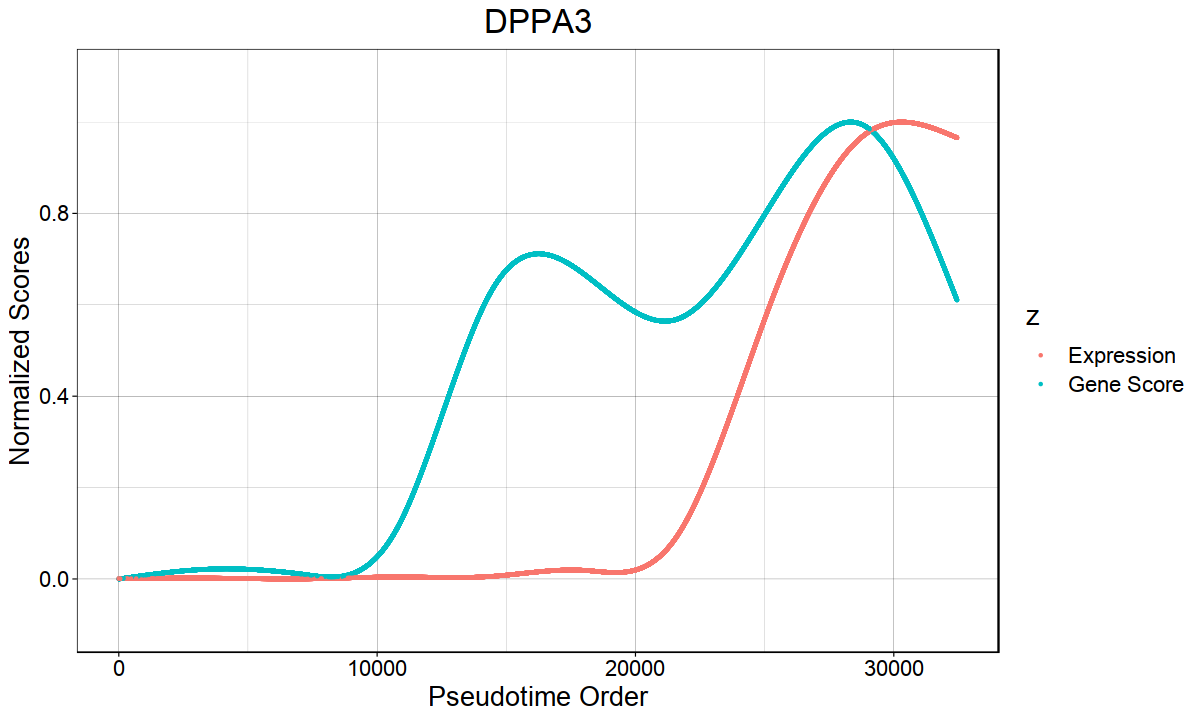

In [370]:
options(repr.plot.width = 10, repr.plot.height = 6)

integrated_plot <- ggplot(plot_df) + 
geom_point(aes (x=x,y=y,colour=z,group=z), stroke=0, size=1) +
xlab("Pseudotime Order") +
ylab("Normalized Scores") +
ggtitle(GENE) +
coord_cartesian(ylim=c(-0.1,1.1)) +
theme_linedraw() +
theme(plot.title = element_text(hjust = 0.5),
     text = element_text(size=16))

# wrap_plots(integrated_plot, day_bar, heights=c(5,1))
integrated_plot

In [371]:
for (i in seq(1,ncol(smoothed_gs_mat),500)) {
    if (smoothed_gs_mat[GENE, i] > smoothed_expr_mat[GENE, i]) {
        integrated_plot <- integrated_plot + annotate("segment", x=i, xend=i, 
                                                      y=smoothed_gs_mat[GENE, i], 
                                                      yend=smoothed_expr_mat[GENE, i],
                                                     alpha=0.5)
    }
}

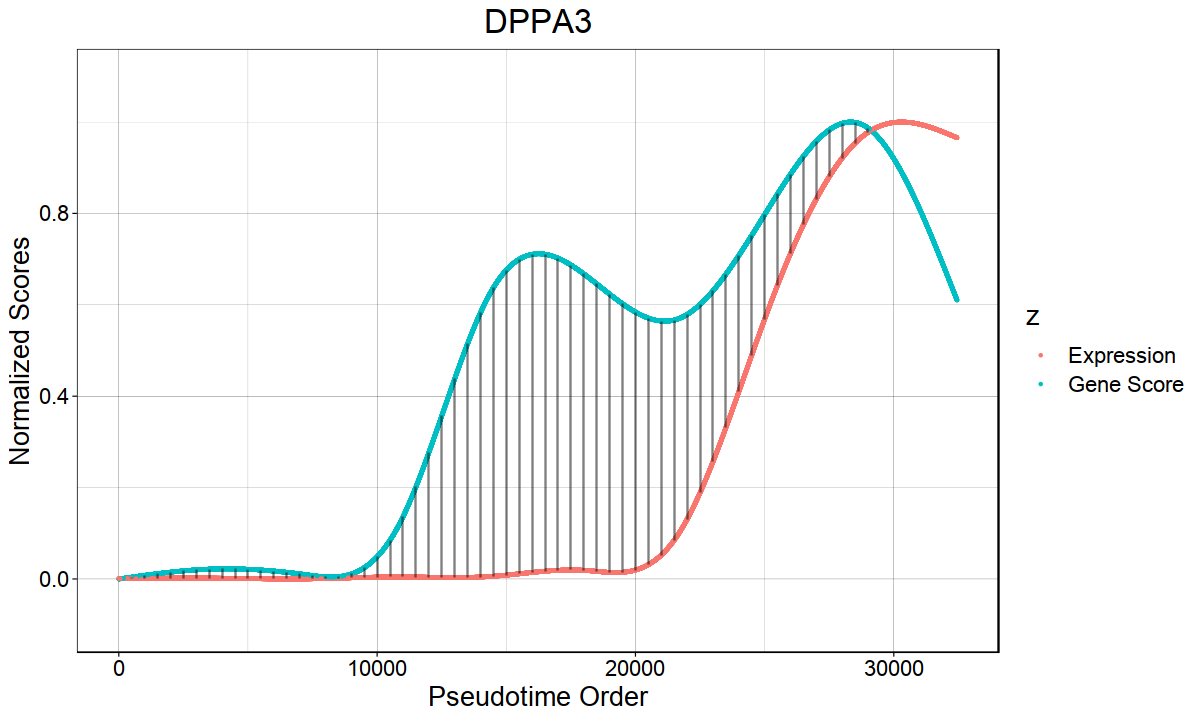

In [372]:
integrated_plot

**Alternate attempt to characterize lead-lag score**

In [341]:
# rise_point <- function(x) { min(which(x > mean(x[1:10])+0.1))}
rise_point <- function(x) { min(which((x > 0.1)&(seq(length(x))>min(which(x==min(x))))))}

In [397]:
sum(corrs > 0.4, na.rm=T)

[1] 4210

In [342]:
(rev(sort((apply(smoothed_expr_agg_mat[genes,], 1, rise_point) - apply(smoothed_gs_agg_mat[genes, ], 1, rise_point)))))

VCX      RFPL2     ZNF729       CDH3  LINC01356  LINC00458       VCX2 
       206        192        186        167        163        157        154 
  ERVH48-1    FAM133A      GCNT2     UNC93A       ZIC2      TERF1     ZNF676 
       153        152        150        148        146        143        142 
     VCX3A    FAM151A       MMP9    TRIM64B     TRIM60      ACTA1       APOE 
       126        123        120        120        119        118        109 
      BRDT      DPPA2    SDCCAG8   FAM189A2 RHOXF1-AS1      PLBD1       MYCN 
       108        106        106        105        103        103        102 
    KHDC3L      TCL1B    KRTCAP3     CRABP1      PRKCB       PIFO  LINC01108 
       100         99         99         97         95         95         94 
 LINC01405      DPPA5      ITGAM       MRS2   MIR205HG       UGP2      FXYD4 
        87         80         72         69         57         55         54 
     BEND4       LCP1      DPPA3     ADAM18      SFRP2      NLRP7       FGF4 
        49         41         41         41         39         38         38 
      PHC1      CCPG1    ZSCAN10     ATP12A     ZNF208       CR1L       GRB7 
        36         32         30         29         27         26         25 
      ALPP     SUCLA2      LRRC6     GNPTAB       DND1      NLRP2     CLEC7A 
        21         20         20         18         18         17         15 
      ART5       CD48      MKRN1       ALPG      USP28       AASS       CDH8 
        15         15         14         14         12         12         10 
     TCEA1      CCND2       CDH1       GPT2       REST       BBS9      N4BP3 
        10          9          8          8          8          7          5 
      DSG2      SUSD3    TACSTD2     ZNF578      TOMM7       MT1F       PDPN 
         4          3          3          2          2          1          0 
     RAB15     ZNF486       GJA1     LEFTY1       TET1     SEPHS1     ZNF600 
        -1         -3         -3         -3        -11        -12        -14 
     CNTD2      ZNF90     HMGCS1      PTH1R  FOXD3-AS1       PIM1      ZFP42 
       -14        -14        -14        -16        -18        -19        -20 
    IFITM1       MEST      DACT1     RBPMS2       HEY2     PRUNE2     DNMT3B 
       -25        -25        -26        -27        -28        -32        -34 
    GPR160     LIN28A      NODAL      VASH2      EPCAM     JARID2     NUDT15 
       -36        -45        -55        -71        -72        -76        -88 
      TJP2  PRKCQ-AS1 
      -148       -165

In [389]:
GENE = "LIN28A"

In [390]:
EXPR_df = data.frame(x=seq(ncol(smoothed_expr_agg_mat)), #sort(cur_pseudotime), 
                    y=smoothed_expr_agg_mat[GENE,],
                    z="Expression")
GS_df = data.frame(x=seq(ncol(smoothed_expr_agg_mat)), #sort(cur_pseudotime)
                  y=smoothed_gs_agg_mat[GENE,],
                  z="Gene Score")

plot_df = rbind(EXPR_df, GS_df)
# plot_df = rbind(EXPR_df, GS_df)

# shuffle
plot_df = plot_df[sample(nrow(plot_df)), ]

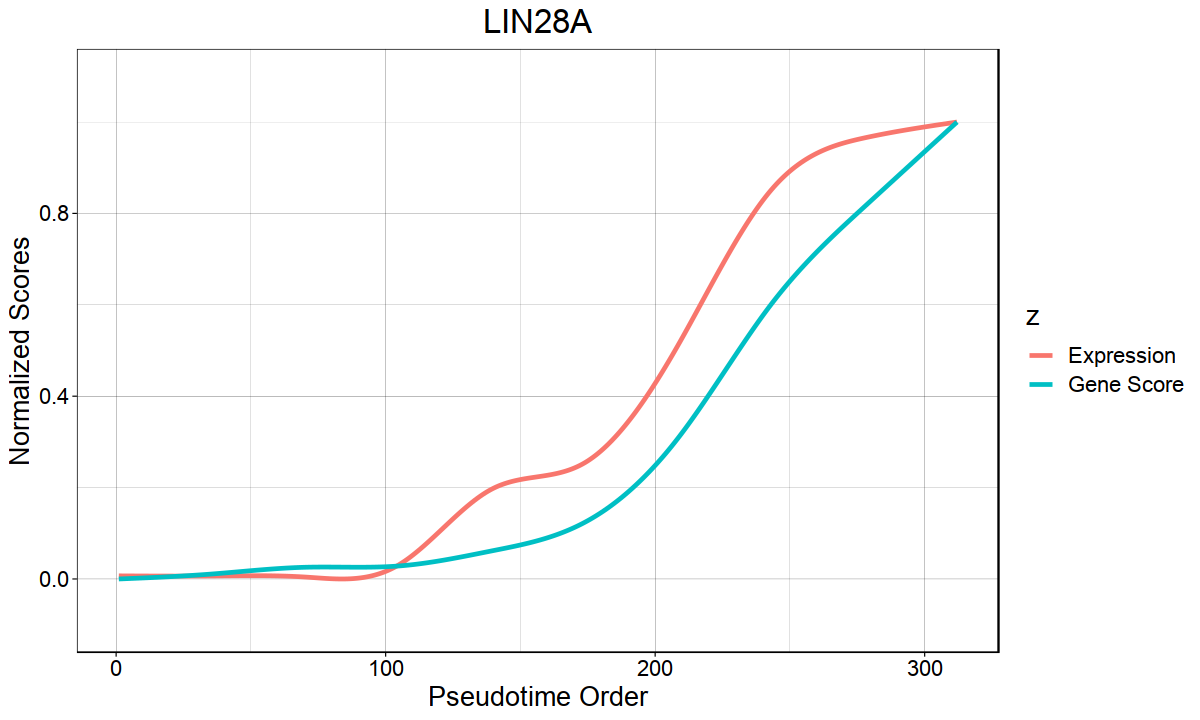

In [391]:
options(repr.plot.width = 10, repr.plot.height = 6)

integrated_plot <- ggplot(plot_df) + 
geom_line(aes (x=x,y=y,colour=z,group=z), size=1) +
xlab("Pseudotime Order") +
ylab("Normalized Scores") +
ggtitle(GENE) +
coord_cartesian(ylim=c(-0.1,1.1)) +
theme_linedraw() +
theme(plot.title = element_text(hjust = 0.5),
     text = element_text(size=16))

# wrap_plots(integrated_plot, day_bar, heights=c(5,1))
integrated_plot

In [392]:
for (i in seq(1,ncol(smoothed_expr_agg_mat), 5)) {
    if (smoothed_gs_agg_mat[GENE, i] > smoothed_expr_agg_mat[GENE, i]) {
        integrated_plot <- integrated_plot + annotate("segment", x=i, xend=i, 
                                                      y=smoothed_gs_agg_mat[GENE, i], 
                                                      yend=smoothed_expr_agg_mat[GENE, i],
                                                     alpha=0.5)
    }
}

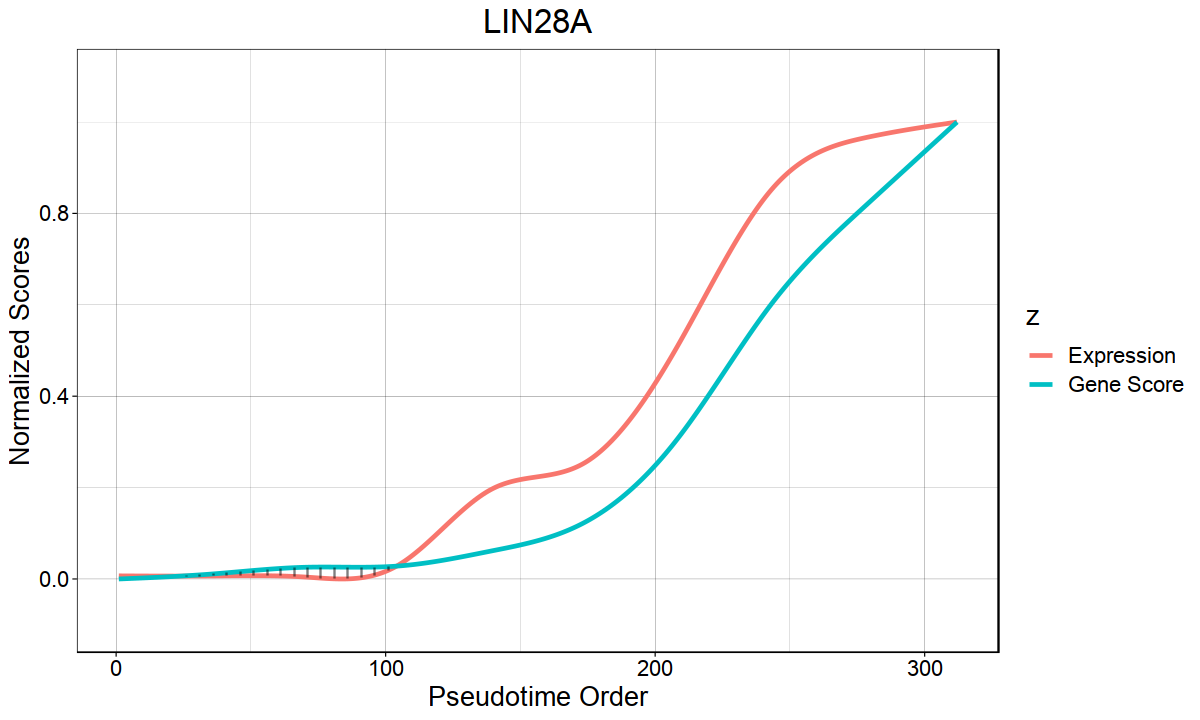

In [393]:
integrated_plot

In [386]:
cor(smoothed_expr_mat[GENE,], smoothed_gs_mat[GENE,])

[1] 0.9651306

In [387]:
corrs[GENE]

ZFP42 
0.918476

## Binned Expression Along Pseudotime

Binned expression to be used for cascade nodes.

In [31]:
ATAC_SEL = which(metaData$cluster_new_id %in% c(1,7,11,12,13,14))

In [32]:
# RNA_SEL = atac2rna_nn$nn.idx[ATAC_SEL, 1]
RNA_SEL = atac2rna_same_cluster_nn[ATAC_SEL, 1]

In [33]:
A = rna@assays$RNA@counts[, RNA_SEL][, order(pseudotime[ATAC_SEL,"dpt_pseudotime"])]

In [34]:
create_sum_matrix <- function(n, r) {
  suppressWarnings(matrix(c(rep(1, r), rep(0, n)), n, n/r))
}

In [36]:
dim(A)

[1] 27632 32447

In [87]:
table(rna$sample[RNA_SEL][order(pseudotime[ATAC_SEL,"dpt_pseudotime"])][1:1600])


  D0  D10  D12  D14   D2   D4   D6   D8 
1220   59    6    6  223   75    2    9 

In [92]:
d0_rna = rowSums(rna@assays$RNA@counts[, rna$sample=="D0"])

In [94]:
d0_rna = 1e6*d0_rna/sum(d0_rna)

In [96]:
d0_rna[c("COL1A1")]

COL1A1 
2215.698

In [98]:
table(metaData$sample[ATAC_SEL[order(pseudotime[ATAC_SEL,"dpt_pseudotime"])]][1:1600])


  D0   D2   D4   D6   D8  D10  D12  D14 
1576   22    2    0    0    0    0    0 

In [95]:
d0_rna[c("POU5F1", "SOX2", "KLF4")]

POU5F1        SOX2        KLF4 
 0.22710702  0.01682274 22.18919694

In [88]:
NUM_PARTITIONS = 20

In [89]:
per_partition = floor(ncol(A)/NUM_PARTITIONS)

In [90]:
binned_expr = as.matrix(A[,1:(NUM_PARTITIONS*per_partition)] %*% create_sum_matrix((NUM_PARTITIONS*per_partition), per_partition))

In [48]:
# median day of every n cells along pseudotime
get_median_day_every_n <- function(days, n=100) {
    rounded_length = floor(length(days)/n)*n

    days_numeric = as.numeric(lapply(strsplit(as.character(days), "D"), "[[", 2))[1:rounded_length]

    averaged_days = colMedians(matrix(days_numeric, n))

    averaged_days = floor(averaged_days/2)*2 # when medians are odd

    averaged_days = paste("D", averaged_days, sep="")    
    
    averaged_days
}

In [50]:
atac_averaged_days = get_median_day_every_n(metaData[ATAC_SEL[order(pseudotime[ATAC_SEL,"dpt_pseudotime"])], "sample"], n=per_partition)
rna_averaged_days = get_median_day_every_n(rna$sample[RNA_SEL[order(pseudotime[ATAC_SEL,"dpt_pseudotime"])]], n=per_partition)

In [52]:
atac_averaged_days
rna_averaged_days

[1] "D0"  "D0"  "D0"  "D0"  "D0"  "D0"  "D0"  "D4"  "D6"  "D6"  "D6"  "D6" 
[13] "D8"  "D12" "D14" "D14" "D14" "D14" "D14" "D14"

[1] "D0"  "D0"  "D0"  "D0"  "D0"  "D0"  "D2"  "D6"  "D6"  "D6"  "D8"  "D8" 
[13] "D8"  "D10" "D12" "D12" "D14" "D14" "D14" "D14"

In [72]:
colnames(binned_expr) = paste(seq(ncol(binned_expr)),
                              paste(paste("ATAC", atac_averaged_days, sep=':'),
                              paste("RNA", rna_averaged_days, sep=':'),
                              sep='/'),
                              sep='-')

In [73]:
head(binned_expr)

1-ATAC:D0/RNA:D0 2-ATAC:D0/RNA:D0 3-ATAC:D0/RNA:D0 4-ATAC:D0/RNA:D0
AL627309.1   2                4                3                3             
AL627309.5  11                8               13                4             
AP006222.2   0                0                0                0             
LINC01409   33               48               51               44             
FAM87B       1                0                2                0             
LINC01128  120              110              151              150             
           5-ATAC:D0/RNA:D0 6-ATAC:D0/RNA:D0 7-ATAC:D0/RNA:D2 8-ATAC:D4/RNA:D6
AL627309.1   0                1                1                4             
AL627309.5   8                9                4               13             
AP006222.2   0                0                0                0             
LINC01409   43               45               54               82             
FAM87B       3                0                0                2             
LINC01128  169              166              239              348             
           9-ATAC:D6/RNA:D6 10-ATAC:D6/RNA:D6 11-ATAC:D6/RNA:D8
AL627309.1   4                3                 5              
AL627309.5   8               10                22              
AP006222.2   0                0                 0              
LINC01409   91               85                97              
FAM87B      10                2                 2              
LINC01128  366              288               322              
           12-ATAC:D6/RNA:D8 13-ATAC:D8/RNA:D8 14-ATAC:D12/RNA:D10
AL627309.1   4                 4                 7                
AL627309.5  23                13                19                
AP006222.2   0                 1                 1                
LINC01409  111                95                58                
FAM87B       3                 4                 4                
LINC01128  299               263               176                
           15-ATAC:D14/RNA:D12 16-ATAC:D14/RNA:D12 17-ATAC:D14/RNA:D14
AL627309.1   3                   4                   9                
AL627309.5  12                  14                  19                
AP006222.2   0                   0                   0                
LINC01409   74                  84                  80                
FAM87B       0                   1                   2                
LINC01128  195                 203                 172                
           18-ATAC:D14/RNA:D14 19-ATAC:D14/RNA:D14 20-ATAC:D14/RNA:D14
AL627309.1   4                   7                   2                
AL627309.5  18                  23                  20                
AP006222.2   0                   0                   1                
LINC01409   75                  79                  62                
FAM87B       1                   0                   2                
LINC01128  163                 161                 155

In [85]:
write.table(binned_expr, 
            "./out/ATAC_20201022_n53906_RNA_20200913_n59369/expr_binned_20_path_1_7_11_12_13_14.tsv",
           sep='\t')

## ChromVAR vs Expression Heatmaps

Sanity checks and linking motif genes to those with RNA.

In [29]:
all(colnames(chromvar) %in% rownames(motifs))

[1] TRUE

In [30]:
ncol(chromvar)

[1] 123

In [31]:
# motif archetypes represented
length(unique(motifs[colnames(chromvar), "Cluster_ID"]))
rev(sort(table(motif_archetypes[motifs[colnames(chromvar), "Cluster_ID"], "Name"])))

[1] 34


        AP1/1      KLF/SP/2          TEAD         RFX/1     OCT4+SOX2 
           12            11             6             6             6 
  Ebox/CAGCTG        ZNF143        RUNX/1         ETS/2          CTCF 
            6             5             5             5             5 
         NRF1           NFY           YY1       TFAP2/1         SIX/1 
            4             4             3             3             3 
    REST/NRSF      KLF/SP/1         KAISO      GC-tract         ETS/1 
            3             3             3             3             3 
   CREB/ATF/2         NFI/3         IRF/2         FOX/5         FOX/4 
            3             2             2             2             2 
 Ebox/CAGATGG Ebox/CACGTG/1    CREB/ATF/1    CCAAT/CEBP           ZFX 
            2             2             2             2             1 
        SOX/1         NFI/1        NFAC/2 Ebox/CACGTG/2 
            1             1             1             1 

In [32]:
rownames(rna)[grep("HOX1", rownames(rna))]

character(0)

In [35]:
# for each archetype, gather all genes present in archetype and look for matching
# genes in RNA expression
selected_archetypes = unique(motifs[colnames(chromvar), "Cluster_ID"])
selected_archetypes_names = motif_archetypes[selected_archetypes, "Name"]

# add missing genes manually
matching_genes_in_archetypes = list()
manually_added_genes_in_archetypes = list()
for (n in selected_archetypes_names) {
    matching_genes_in_archetypes[[n]] = c()
    manually_added_genes_in_archetypes[[n]] = c()
}

manually_added_genes_in_archetypes[["Ebox/CAGCTG"]] = c("BHLHA15", "TCF3") # TFE2 -> TCF3
manually_added_genes_in_archetypes[["CREB/ATF/1"]] = c("FOS", "FOSB", "FOSL1", "FOSL2", "JUN", "JUND")
manually_added_genes_in_archetypes[["AP1/1"]] = c("BATF", "NFE2L1") # for NF2L1
manually_added_genes_in_archetypes[["FOX/4"]] = c("AR") # AR for ANDR, FOXA2 not present in RNA
manually_added_genes_in_archetypes[["IRF/2"]] = c("BCL11A") # for BC11A
manually_added_genes_in_archetypes[["KLF/SP/2"]] = c("ZBTB17", "ZNF281")
manually_added_genes_in_archetypes[["GC-tract"]] = c("ZNF341", "ZNF467", "ZNF770", "ZSCAN22")
manually_added_genes_in_archetypes[["OCT4+SOX2"]] = c("POU3F1", "POU5F1")
manually_added_genes_in_archetypes[["NFI/1"]] = c() # TLX1 not present in RNA
manually_added_genes_in_archetypes[["NFY"]] = c("DUX4") # ortholog of mouse DUX
manually_added_genes_in_archetypes[["NFAC/2"]] = c("NFATC1") # for NFAC1
manually_added_genes_in_archetypes[["RUNX/1"]] = c("CBFB") # for PEBB
manually_added_genes_in_archetypes[["ZNF143"]] = c("THAP11", "ZNF143")
manually_added_genes_in_archetypes[["Ebox/CAGATGG"]] = c("NEUROD1", "NEUROD2", "NEUROG2", "TAL1", "TCF3", "TWIST1")

for (a in selected_archetypes) {
        arch_name  = motif_archetypes[a, "Name"]
        all_genes_in_archetypes = unique(toupper(motifs[motifs$Cluster_ID %in% a, "Gene"]))

        # only those with missing
        if (sum(!all_genes_in_archetypes %in% rownames(rna)) > 0) {
                cat(arch_name)
        cat("\n------\n")

        cat("Missing        : ")
        cat(sort(all_genes_in_archetypes[!all_genes_in_archetypes %in% rownames(rna)]))
        cat("\n")

        cat("Matching       : ")
        cat(sort(all_genes_in_archetypes[all_genes_in_archetypes %in% rownames(rna)]))
        cat("\n")

        cat("Manually added : ")
        cat(sort(manually_added_genes_in_archetypes[[arch_name]]))
        cat("\n\n")
    }
    
    matching_genes_in_archetypes[[arch_name]] = c(all_genes_in_archetypes[all_genes_in_archetypes %in% rownames(rna)],
                                                 manually_added_genes_in_archetypes[[arch_name]])
}

TFAP2/1
------
Missing        : AP2A AP2B AP2C TCFAP2A
Matching       : TFAP2A TFAP2B TFAP2C
Manually added : 

Ebox/CAGCTG
------
Missing        : BHA15 TFE2 ZBT18 ZNF238
Matching       : ASCL1 ASCL2 MSC MYF6 MYOD1 MYOG NHLH1 TCF12 TCF21 TFAP4 TWIST1 ZBTB18
Manually added : BHLHA15 TCF3

CREB/ATF/1
------
Missing        : FOS+JUN FOSB+JUN FOSB+JUNB FOSL1+JUN FOSL1+JUND FOSL2+JUN FOSL2+JUNB FOSL2+JUND JUN+JUNB
Matching       : ATF1 ATF2 ATF3 CREB1 CREM JUNB
Manually added : FOS FOSB FOSL1 FOSL2 JUN JUND

AP1/1
------
Missing        : BATF+JUN FOS+JUN FOS+JUNB FOS+JUND FOSB+JUNB FOSL1+JUN FOSL1+JUNB FOSL1+JUND FOSL2+JUN FOSL2+JUNB FOSL2+JUND JUN+JUNB NF2L1
Matching       : ATF3 FOS FOSB FOSL1 FOSL2 JDP2 JUN JUNB JUND NFE2
Manually added : BATF NFE2L1

FOX/4
------
Missing        : ANDR FOXA2
Matching       : FOXA1 FOXA3 FOXB1 FOXC1 FOXC2 FOXD3 FOXK1 FOXK2 FOXM1 FOXO1 FOXP1 FOXP2
Manually added : AR

IRF/2
------
Missing        : BC11A STAT1+STAT2
Matching       : IRF1 IRF2 IRF3 IRF4 IRF

Trajectory seleciton and plotting.

In [36]:
ATAC_SEL = which(metaData$cluster_new_id %in% c(1,7,11,12,13,14))

In [37]:
# RNA_SEL = atac2rna_nn$nn.idx[ATAC_SEL, 1]
RNA_SEL = atac2rna_same_cluster_nn[ATAC_SEL, 1]

In [38]:
all(rownames(metaData)[ATAC_SEL] %in% rownames(chromvar))
subset_atac_sel = ATAC_SEL[rownames(metaData)[ATAC_SEL] %in% rownames(chromvar)]

# subset_rna_sel = atac2rna_nn$nn.idx[subset_atac_sel, 1] # without same cluster NN constraint
subset_rna_sel = atac2rna_same_cluster_nn[subset_atac_sel, 1]
length(subset_atac_sel)

[1] TRUE

[1] 32447

In [39]:
cur_pseudotime = pseudotime[subset_atac_sel,"dpt_pseudotime"]

In [40]:
path_chromvar = t(chromvar[subset_atac_sel, ][order(cur_pseudotime), ])

In [41]:
path_expr = rna@assays$RNA@data[, subset_rna_sel][, order(cur_pseudotime)]

In [42]:
dim(path_chromvar)

[1]   123 32447

In [43]:
dim(path_expr)

[1] 27632 32447

In [44]:
SEL_ARCHETYPE = "TEAD"

In [45]:
motifs_selected = rownames(path_chromvar)[motif_archetypes[motifs[rownames(path_chromvar), "Cluster_ID"], "Name"]==SEL_ARCHETYPE]

cor(t(path_chromvar[motifs_selected ,]))

TEAD1_HUMAN.H11MO.0.A TEAD3_MA0808.1 TEAD3_TEA_1
TEAD1_HUMAN.H11MO.0.A 1.0000000             0.6091151      0.2826578  
TEAD3_MA0808.1        0.6091151             1.0000000      0.1678585  
TEAD3_TEA_1           0.2826578             0.1678585      1.0000000  
TEAD3_TEA_2           0.6091151             1.0000000      0.1678585  
TEAD4_HUMAN.H11MO.0.A 0.8698389             0.6508949      0.2366426  
TEAD4_MOUSE.H11MO.0.A 0.7612891             0.5748983      0.3981561  
                      TEAD3_TEA_2 TEAD4_HUMAN.H11MO.0.A TEAD4_MOUSE.H11MO.0.A
TEAD1_HUMAN.H11MO.0.A 0.6091151   0.8698389             0.7612891            
TEAD3_MA0808.1        1.0000000   0.6508949             0.5748983            
TEAD3_TEA_1           0.1678585   0.2366426             0.3981561            
TEAD3_TEA_2           1.0000000   0.6508949             0.5748983            
TEAD4_HUMAN.H11MO.0.A 0.6508949   1.0000000             0.8125894            
TEAD4_MOUSE.H11MO.0.A 0.5748983   0.8125894             1.0000000

In [46]:
gene_x_motif_cor = cor(t(path_chromvar[motifs_selected ,]),
                       as.matrix(t(path_expr[matching_genes_in_archetypes[[SEL_ARCHETYPE]],])))
max(gene_x_motif_cor, na.rm=T)
min(gene_x_motif_cor, na.rm=T)
gene_x_motif_cor

[1] 0.2207725

[1] -0.2317739

TEAD1        TEAD4      TEAD2       TEAD3      
TEAD1_HUMAN.H11MO.0.A  0.118184323 -0.1067384  0.03559604 0.078879170
TEAD3_MA0808.1         0.220772500 -0.2317739  0.06441248 0.148316051
TEAD3_TEA_1           -0.001419341  0.0151610 -0.00805876 0.002336608
TEAD3_TEA_2            0.220772500 -0.2317739  0.06441248 0.148316051
TEAD4_HUMAN.H11MO.0.A  0.138156649 -0.1358774  0.03790494 0.095899676
TEAD4_MOUSE.H11MO.0.A  0.118057458 -0.1151349  0.03186319 0.080418947

Within archetypes, remove highly correlated motifs.

In [184]:
WITHIN_ARCH_CORR_CUTOFF = 0.2

In [185]:
selected_archetypes = unique(motifs[colnames(chromvar), "Cluster_ID"])
motifs_corr_filtered = list()

for (a in selected_archetypes) {
    arch_name = motif_archetypes[a, "Name"]
    cur_motifs = rownames(path_chromvar)[motifs[rownames(path_chromvar), "Cluster_ID"] == a]
    
    
    if (length(cur_motifs) == 1) {
        motifs_corr_filtered[[arch_name]] = cur_motifs
    }
    
    else {
        corrs = cor(t(path_chromvar[cur_motifs, ]))
        
        # bring those that are correlated with most others to the top
        corrs = corrs[rev(order(rowSums(corrs))), rev(order(rowSums(corrs)))]
        
        # select top one by default
        cur_selected = c(1)
        
        # check others against the ones selected
        for (i in seq(2, nrow(corrs))) {
            is_cor_with_selected = FALSE
            for (j in cur_selected) {
                if (corrs[i, j] > WITHIN_ARCH_CORR_CUTOFF) {
                    is_cor_with_selected = TRUE
                    break
                }
            }
            
            if (is_cor_with_selected == FALSE) {
                cur_selected = c(cur_selected, i)
            }
        }
        
        motifs_corr_filtered[[arch_name]] = rownames(corrs)[cur_selected]
          
        # sanity check max correlation between selected TFs chromvars
#         if (length(motifs_corr_filtered[[arch_name]]) > 1 ) {
#             corr_among_selected = cor(t(path_chromvar[motifs_corr_filtered[[arch_name]], ]))
#             diag(corr_among_selected) = 0
#             print(max(corr_among_selected))
#         }
    }
} 

In [186]:
length(unlist(motifs_corr_filtered))

[1] 36

In [187]:
motifs_corr_filtered

$`TFAP2/1`
[1] "AP2C_HUMAN.H11MO.0.A"

$`Ebox/CAGCTG`
[1] "ZNF238_C2H2_2"

$`CREB/ATF/1`
[1] "CREB1_MA0018.3"       "ATF1_MOUSE.H11MO.0.B"

$`AP1/1`
[1] "FOS+JUND_MA1141.1"

$`CCAAT/CEBP`
[1] "CEBPB_MOUSE.H11MO.0.A"

$`CREB/ATF/2`
[1] "JDP2_MA0656.1"

$CTCF
[1] "CTCF_HUMAN.H11MO.0.A"

$`ETS/1`
[1] "ELK4_MA0076.2"

$`ETS/2`
[1] "ETS1_MOUSE.H11MO.0.A"

$`FOX/5`
[1] "FOXL2_MOUSE.H11MO.0.C"

$`FOX/4`
[1] "FOXC2_MA0846.1"

$`IRF/2`
[1] "IRF1_MOUSE.H11MO.0.A"

$KAISO
[1] "KAISO_MOUSE.H11MO.0.B"

$`KLF/SP/1`
[1] "Klf1_MA0493.1"

$`KLF/SP/2`
[1] "SP3_MOUSE.H11MO.0.B"

$`GC-tract`
[1] "TAF1_HUMAN.H11MO.0.A"

$`Ebox/CACGTG/2`
[1] "MYC_HUMAN.H11MO.0.A"

$`OCT4+SOX2`
[1] "NANOG_HUMAN.H11MO.0.A"

$`NFI/3`
[1] "NFIC_HUMAN.H11MO.0.A"

$`NFI/1`
[1] "NFIB_MOUSE.H11MO.0.C"

$NFY
[1] "NFYB_MOUSE.H11MO.0.A"

$NRF1
[1] "NRF1_HUMAN.H11MO.0.A"

$`NFAC/2`
[1] "PRDM6_HUMAN.H11MO.0.C"

$`REST/NRSF`
[1] "REST_MA0138.2"

$`RFX/1`
[1] "RFX1_MOUSE.H11MO.0.A" "RFX2_HUMAN.H11MO.0.A"

$`RUNX/1`
[1] "RUNX1_MOUSE.H11MO.0.A"

$`SIX/1`
[1] "SIX2_MOUSE.H11MO.0.A"

$`SOX/1`
[1] "Sox3_MA0514.1"

$TEAD
[1] "TEAD4_HUMAN.H11MO.0.A"

$ZNF143
[1] "ZN143_HUMAN.H11MO.0.A"

$`Ebox/CAGATGG`
[1] "TWST1_MOUSE.H11MO.0.B"

$YY1
[1] "TYY1_HUMAN.H11MO.0.A"

$`Ebox/CACGTG/1`
[1] "USF2_MOUSE.H11MO.0.A"

$ZFX
[1] "ZFX_MOUSE.H11MO.0.B"

In [188]:
motifs_corr_filtered_unlisted = unlist(motifs_corr_filtered)
names(motifs_corr_filtered_unlisted) = NULL

Remove motifs that don't correlate well with pseudotime.

In [189]:
PSEUDOTIME_CORR_CUTOFF = 0.2

In [190]:
cv_corr_pst = apply(path_chromvar[motifs_corr_filtered_unlisted, ], 1,
                    function(x) {cor(x, seq(1,length(x)))})
head(sort(abs(cv_corr_pst)))

ATF1_MOUSE.H11MO.0.B SIX2_MOUSE.H11MO.0.A IRF1_MOUSE.H11MO.0.A 
         0.002076297          0.044139273          0.052262184 
RFX2_HUMAN.H11MO.0.A  MYC_HUMAN.H11MO.0.A USF2_MOUSE.H11MO.0.A 
         0.114966370          0.172023660          0.225966359

In [191]:
motifs_corr_filtered_unlisted = motifs_corr_filtered_unlisted[abs(cv_corr_pst)>PSEUDOTIME_CORR_CUTOFF]

In [192]:
length(motifs_corr_filtered_unlisted)

[1] 31

Expression matches for each selected motif, from within genes linked to its archetypes.

In [193]:
linked_genes = c()
linked_gene_corrs = c()

for (m in motifs_corr_filtered_unlisted) {
    cur_motif_arch = motif_archetypes[motifs[m, "Cluster_ID"], "Name"]
    
    if (length(matching_genes_in_archetypes[[cur_motif_arch]]) == 1) {
        linked_genes = c(linked_genes, matching_genes_in_archetypes[[cur_motif_arch]][1])
        linked_gene_corrs = c(linked_gene_corrs,
                            cor(unlist(path_expr[matching_genes_in_archetypes[[cur_motif_arch]][1], ]),
                               path_chromvar[m, ]))
    }
    
    else {
        # pick one with highest correlation
        corrs = cor(t(as.matrix(path_expr[matching_genes_in_archetypes[[cur_motif_arch]], ])),
                   path_chromvar[m, ])
        
        max_idx = which.max(corrs)
        
        linked_genes = c(linked_genes, rownames(corrs)[max_idx])
        linked_gene_corrs = c(linked_gene_corrs,
                             corrs[max_idx])
        
    }
}

names(linked_genes) = motifs_corr_filtered_unlisted
names(linked_gene_corrs) = motifs_corr_filtered_unlisted

Warning message in cor(t(as.matrix(path_expr[matching_genes_in_archetypes[[cur_motif_arch]], :
“the standard deviation is zero”
Warning message in cor(t(as.matrix(path_expr[matching_genes_in_archetypes[[cur_motif_arch]], :
“the standard deviation is zero”


In [194]:
length(unique(linked_genes))

[1] 29

In [213]:
rev(sort(table(linked_genes)))

linked_genes
  NFIC   ETV4 ZNF770 ZNF143    ZFX  ZFP42 ZBTB33 TWIST1 TFAP2C  TEAD1  TCF21 
     2      2      1      1      1      1      1      1      1      1      1 
  SOX2  SALL4  RUNX1   RFX5   REST POU5F1   NRF1   NFYB NFATC1   KLF4   JUNB 
     1      1      1      1      1      1      1      1      1      1      1 
   JUN   HEY2  FOXF2  FOXC2    FOS  CTCFL  CEBPD 
     1      1      1      1      1      1      1 

In [196]:
linked_genes

AP2C_HUMAN.H11MO.0.A         ZNF238_C2H2_2        CREB1_MA0018.3 
             "TFAP2C"               "TCF21"                 "FOS" 
    FOS+JUND_MA1141.1 CEBPB_MOUSE.H11MO.0.A         JDP2_MA0656.1 
               "JUNB"               "CEBPD"                 "JUN" 
 CTCF_HUMAN.H11MO.0.A         ELK4_MA0076.2  ETS1_MOUSE.H11MO.0.A 
              "CTCFL"                "ETV4"                "ETV4" 
FOXL2_MOUSE.H11MO.0.C        FOXC2_MA0846.1 KAISO_MOUSE.H11MO.0.B 
              "FOXF2"               "FOXC2"              "ZBTB33" 
        Klf1_MA0493.1   SP3_MOUSE.H11MO.0.B  TAF1_HUMAN.H11MO.0.A 
               "KLF4"               "SALL4"              "ZNF770" 
NANOG_HUMAN.H11MO.0.A  NFIC_HUMAN.H11MO.0.A  NFIB_MOUSE.H11MO.0.C 
             "POU5F1"                "NFIC"                "NFIC" 
 NFYB_MOUSE.H11MO.0.A  NRF1_HUMAN.H11MO.0.A PRDM6_HUMAN.H11MO.0.C 
               "NFYB"                "NRF1"              "NFATC1" 
        REST_MA0138.2  RFX1_MOUSE.H11MO.0.A RUNX1_MOUSE.H11MO.0.A 
               "REST"                "RFX5"               "RUNX1" 
        Sox3_MA0514.1 TEAD4_HUMAN.H11MO.0.A ZN143_HUMAN.H11MO.0.A 
               "SOX2"               "TEAD1"              "ZNF143" 
TWST1_MOUSE.H11MO.0.B  TYY1_HUMAN.H11MO.0.A  USF2_MOUSE.H11MO.0.A 
             "TWIST1"               "ZFP42"                "HEY2" 
  ZFX_MOUSE.H11MO.0.B 
                "ZFX"

In [197]:
# motifs correlated with manually added genes
linked_genes[linked_genes %in% unlist(manually_added_genes_in_archetypes)]

CREB1_MA0018.3         JDP2_MA0656.1  TAF1_HUMAN.H11MO.0.A 
                "FOS"                 "JUN"              "ZNF770" 
NANOG_HUMAN.H11MO.0.A PRDM6_HUMAN.H11MO.0.C ZN143_HUMAN.H11MO.0.A 
             "POU5F1"              "NFATC1"              "ZNF143" 
TWST1_MOUSE.H11MO.0.B 
             "TWIST1"

In [198]:
minmax_normalize <- function(x)
{
    x = ((x- quantile(x, 0.02)) /(quantile(x, 0.98)-quantile(x, 0.02)))
    x[x<0] = 0
    x[x>1] = 1
    x
}

In [199]:
path_filtered_minmax_chromvar = t(apply(path_chromvar[motifs_corr_filtered_unlisted, ], 
                                        1, minmax_normalize))

In [200]:
path_filtered_minmax_expr = t(apply(path_expr[linked_genes, ], 
                                        1, minmax_normalize))

In [201]:
average_pseudotime <- function(x) {
    return (sum(x*seq(1,length(x)))/sum(x))
}

In [202]:
# calculate average pseudotime weighted by chromvar
avg_pst = apply(path_filtered_minmax_chromvar, 1, average_pseudotime)            

In [203]:
cv_dist = dist(path_filtered_minmax_chromvar)
cluster = hclust(cv_dist, method="complete")
dendrogram = as.dendrogram(cluster)
    
# reorder based on average pseudotime of motifs
dendrogram = reorder(dendrogram, avg_pst, mean)

In [204]:
rownames(path_filtered_minmax_chromvar)[order.dendrogram(dendrogram)]

[1] "FOS+JUND_MA1141.1"     "RUNX1_MOUSE.H11MO.0.A" "FOXL2_MOUSE.H11MO.0.C"
 [4] "FOXC2_MA0846.1"        "CEBPB_MOUSE.H11MO.0.A" "JDP2_MA0656.1"        
 [7] "CREB1_MA0018.3"        "ZNF238_C2H2_2"         "TWST1_MOUSE.H11MO.0.B"
[10] "TEAD4_HUMAN.H11MO.0.A" "NFIB_MOUSE.H11MO.0.C"  "NFIC_HUMAN.H11MO.0.A" 
[13] "PRDM6_HUMAN.H11MO.0.C" "USF2_MOUSE.H11MO.0.A"  "KAISO_MOUSE.H11MO.0.B"
[16] "REST_MA0138.2"         "NRF1_HUMAN.H11MO.0.A"  "TYY1_HUMAN.H11MO.0.A" 
[19] "NFYB_MOUSE.H11MO.0.A"  "ELK4_MA0076.2"         "ETS1_MOUSE.H11MO.0.A" 
[22] "ZN143_HUMAN.H11MO.0.A" "RFX1_MOUSE.H11MO.0.A"  "CTCF_HUMAN.H11MO.0.A" 
[25] "TAF1_HUMAN.H11MO.0.A"  "ZFX_MOUSE.H11MO.0.B"   "AP2C_HUMAN.H11MO.0.A" 
[28] "Sox3_MA0514.1"         "Klf1_MA0493.1"         "NANOG_HUMAN.H11MO.0.A"
[31] "SP3_MOUSE.H11MO.0.B"

In [223]:
path_chromvar_to_plot = path_filtered_minmax_chromvar[order.dendrogram(dendrogram), ]
rownames(path_chromvar_to_plot) = paste(rownames(path_chromvar_to_plot),
                                       motif_archetypes[motifs[rownames(path_chromvar_to_plot), "Cluster_ID"], "Name"],
                                       sep=' - ')
head(path_chromvar_to_plot, 2)

D0_AACGCGAGAAGGACCA D0_CCTTGGTACTAGACAA
FOS+JUND_MA1141.1 - AP1/1      0.6253629           0.4838821          
RUNX1_MOUSE.H11MO.0.A - RUNX/1 0.7659250           0.5280012          
                               D0_CAAGAGTCTAGTGAGC D0_GATCGCGTGACGAGCA
FOS+JUND_MA1141.1 - AP1/1      0.5881980           0.6865184          
RUNX1_MOUSE.H11MO.0.A - RUNX/1 0.5527709           0.7137009          
                               D0_AACGCGAGATTGCGCG D0_TACCCGTTGTGCGGCT
FOS+JUND_MA1141.1 - AP1/1      0.6539814           0.6090240          
RUNX1_MOUSE.H11MO.0.A - RUNX/1 0.7789541           0.8720451          
                               D0_GGACACCTGACAGGTG D0_TCGCGGAACTACTTTC
FOS+JUND_MA1141.1 - AP1/1      0.7202345           0.6360718          
RUNX1_MOUSE.H11MO.0.A - RUNX/1 0.7485600           0.6223837          
                               D0_CAGCCGATGTTATGGC D0_TTCCCTGGAGGGATTG ⋯
FOS+JUND_MA1141.1 - AP1/1      0.5194455           0.6012004           ⋯
RUNX1_MOUSE.H11MO.0.A - RUNX/1 0.5533114           0.6910039           ⋯
                               D14_CATTCTATGACAGGTG D14_GCACAATACATCATGC
FOS+JUND_MA1141.1 - AP1/1      0.22016910           0.1351829           
RUNX1_MOUSE.H11MO.0.A - RUNX/1 0.01364443           0.1210637           
                               D14_TCACCCATGCAGATTC D14_TCCGTTGTGTCCAATG
FOS+JUND_MA1141.1 - AP1/1      0.09434372           0.2323425           
RUNX1_MOUSE.H11MO.0.A - RUNX/1 0.14258409           0.1206315           
                               D14_CGTACAAACACGCGAA D14_CTTGCGGGAAAATGCA
FOS+JUND_MA1141.1 - AP1/1      0.3205043            0.1433444           
RUNX1_MOUSE.H11MO.0.A - RUNX/1 0.5464664            0.3818129           
                               D14_GGCACAAGACATACTG D14_GGTGTAACTGTTAGTC
FOS+JUND_MA1141.1 - AP1/1      0.1600673            0.1478570           
RUNX1_MOUSE.H11MO.0.A - RUNX/1 0.5958062            0.2942606           
                               D14_ATAGGGTCTCGGTTTA D14_GGTTGGAGATGCTCAA
FOS+JUND_MA1141.1 - AP1/1      0.09361776           0.2189942           
RUNX1_MOUSE.H11MO.0.A - RUNX/1 0.51840446           0.6795121

In [224]:
library(viridis)
library(scales)

In [225]:
quantile(path_chromvar_to_plot, c(0.05, .95))

5%        95% 
0.05830693 0.89082825

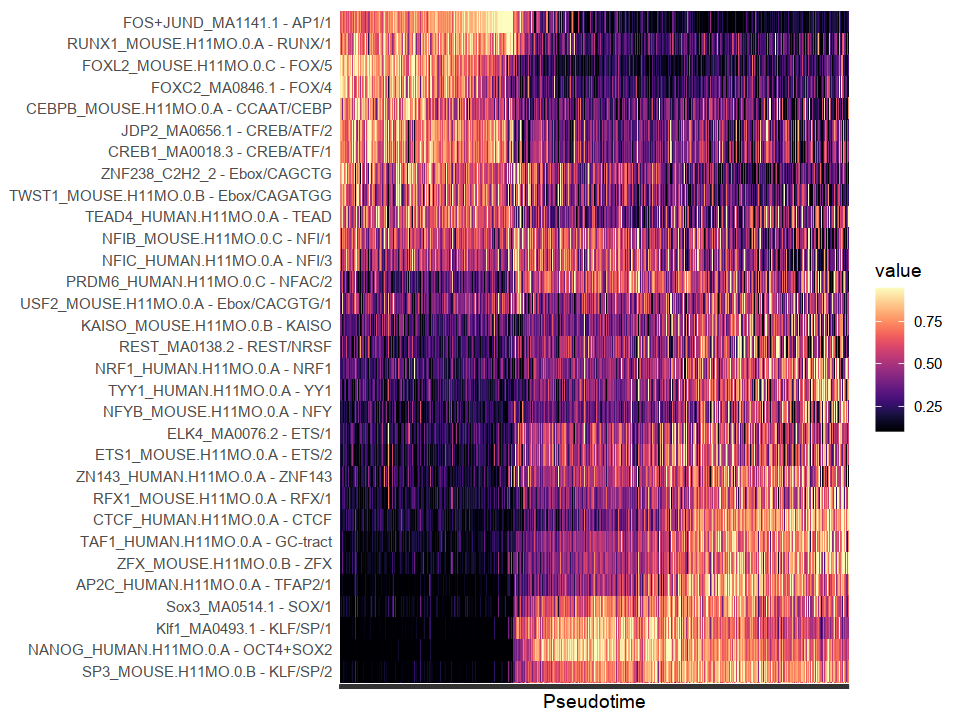

In [226]:
options(repr.plot.width = 8, repr.plot.height = 6)

idxs = seq(1, ncol(path_chromvar_to_plot), 10) # if subsample
melted_df_to_plot = reshape2::melt(path_chromvar_to_plot[, idxs])
ggplot(data = melted_df_to_plot, 
       mapping = aes(x = Var2,
                     y = factor(Var1, 
                                levels=rev(levels(Var1))),
                     fill = value)) +
geom_tile()  + ylab(NULL) + xlab("Pseudotime") +  
geom_raster(aes(fill=value)) +
scale_fill_viridis(limits=c(0.1, .95), oob=squish, option = "A") +
# scale_fill_viridis(option="A") + 
# scale_fill_gradient2(low="red", mid="black", high="blue") 
# theme_classic() +
theme(axis.text.x=element_blank(),
#       axis.text.y=element_blank(),
      axis.ticks.y=element_blank())

# ggsave(sprintf("figs/%s_heatmap_idr_n%d.jpeg", format(Sys.Date(), format='%Y%m%d'), length(table(pr_mb))),
#        dpi=1000)

In [220]:
path_expr_to_plot = path_filtered_minmax_expr[order.dendrogram(dendrogram), ]
rnames = rownames(path_expr_to_plot)
rownames(path_expr_to_plot) = seq(1,nrow(path_expr_to_plot)) # genes may be repeated hence need to use unique
head(path_expr_to_plot, 2)

GTGCTGGAGGACGGAG-1 TTTCCTCGTCTTGTCC-1 TACTTGTCAGAACTTC-1 CTCATGCGTCAGGCAA-5
1 1                  0.8828423          0.6691199          0.0000000         
2 0                  0.0000000          0.0000000          0.4737236         
  AAGATAGCACCATATG-1 GATGATCAGCAGCCCT-3 TCCTTCTCAAGCACAG-3 CGAGTGCGTAGAAACT-2
1 0.7687183          0.4722349          0.3248399          0.7083401         
2 0.0000000          0.5533602          0.2690939          0.0000000         
  GTTACCCCAGTGGCTC-2 AGCGCCACAGCGACCT-7 ⋯ GCTACAACACATTGTG-8 TGTTACTGTCCTTGTC-8
1 0.0000000          0.4892174          ⋯ 0                  0                 
2 0.3719367          0.3295967          ⋯ 0                  0                 
  TCACTCGAGTTATGGA-7 GAGTGAGGTTGTCATG-7 TTTCAGTGTACGATCT-8 TACAGGTGTCGTCGGT-7
1 0                  0                  0.272843           0                 
2 0                  0                  0.000000           0                 
  ATTACTCCAGTTCACA-8 GGCGTCAAGTGGCGAT-7 CATTGAGCACAAAGTA-8 TATCAGGTCGCTGTCT-8
1 0.331876           0                  0.2540917          0                 
2 0.000000           0                  0.0000000          0

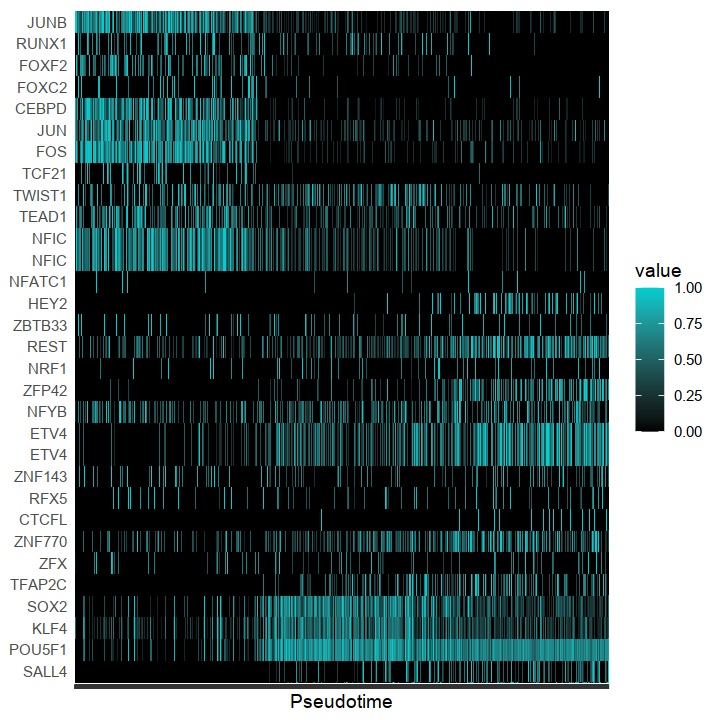

In [222]:
options(repr.plot.width = 6, repr.plot.height = 6)

idxs = seq(1, ncol(path_expr_to_plot), 10) # if subsample
melted_df_to_plot = reshape2::melt(path_expr_to_plot[, idxs])
ggplot(data = melted_df_to_plot, 
       mapping = aes(x = Var2,
                     y = factor(rev(Var1)), 
                     fill = value)) +
geom_tile()  + ylab(NULL) + xlab("Pseudotime") +  
scale_y_discrete(labels=rev(rnames)) + 
geom_raster(aes(fill=value)) +
# scale_fill_viridis(limits=c(0, 1), oob=squish, option = "C") +
# scale_fill_viridis(option="A") + 
scale_fill_gradient(limits=c(0,1), low="black", high="darkturquoise") +
# theme_classic() +
theme(axis.text.x=element_blank(),
#       axis.text.y=element_blank(),
      axis.ticks.y=element_blank())

# ggsave(sprintf("figs/%s_heatmap_idr_n%d.jpeg", format(Sys.Date(), format='%Y%m%d'), length(table(pr_mb))),
#        dpi=1000)

---

In [148]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /users/surag/anaconda3/envs/r36_cran/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] DESeq2_1.26.0                     BSgenome.Hsapiens.UCSC.hg38_1.4.1
 [3] BSgenome_1.54.0                   rtracklayer_1.46.0               
 [5] Biostrings_2.54.0                 XVector_0.26.0                   
 [7] mgcv_1.8-31                       nlme_3.1-147     